# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

### Solution Approach

- Data Preparation
- Performing EDA
- Model Building
- Feature Selection
- Final Observations

For the entire solution both the seen(train.csv) and unseen(test.csv) dataset need to be considered.

# 1. Loading dependencies & datasets

In [1036]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm


from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE



import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Loading the input files
- train.csv - Contains the input data with both independent and dependent variable. This file to be used for training and building model.
- test.csv - Contains the input data with only independent variable. This file to be used for testing the built model on kaggle competition benchmark.

In [1037]:
telecom_df = pd.read_csv("../../datasets/telecom-churn/train.csv")
unseen_telecom_df = pd.read_csv("../../datasets/telecom-churn/test.csv")
sample_df = pd.read_csv("../../datasets/telecom-churn/sample.csv")
data_dict_df = pd.read_csv("../../datasets/telecom-churn/data_dictionary.csv")

print(telecom_df.shape)
print(unseen_telecom_df.shape)
print(sample_df.shape)
print(data_dict_df.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [1038]:
telecom_df.info(verbose=True, show_counts=True)
print('Number of rows are: ', telecom_df.shape[0])
print('Number of cols are: ', telecom_df.shape[1])
print('Number of duplicated rows are: ', telecom_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

# 2. Data Preparation

## 2.1 Dropping columns with all NULL Values
- Drop any column that has all the values as null
- Drop any column that has single value across the entire column
- Drop the id column as this is not useful for making any prediction

In [1039]:
all_null_value_cols = [col for col in telecom_df.columns if telecom_df[col].isnull().all() == True]
unseen_all_null_value_cols = [col for col in unseen_telecom_df.columns if unseen_telecom_df[col].isnull().all() == True]

print('Columns with all null values are:', all_null_value_cols)
print('Number of columns with all null values are: ', len(all_null_value_cols))

print('Columns with all null values in unseen data are:', unseen_all_null_value_cols)
print('Number of columns with all null values in unseen data are: ', len(unseen_all_null_value_cols))

Columns with all null values are: []
Number of columns with all null values are:  0
Columns with all null values in unseen data are: []
Number of columns with all null values in unseen data are:  0


##### Dropping columns with SINGLE Values

In [1040]:
single_value_cols = []
for col in telecom_df.columns:
    if telecom_df[col].nunique() == 1:
        single_value_cols.append(col)
print('Columns with single value: ', single_value_cols)
print('Number of columns with sigle values are: ', len(single_value_cols))
telecom_df = telecom_df.drop(telecom_df[single_value_cols], axis = 1)
unseen_telecom_df = unseen_telecom_df.drop(unseen_telecom_df[single_value_cols], axis = 1)
print('Dropped all the columns with single values in available data. Shape now is: ', telecom_df.shape)
print('Dropped all the columns with single values in unseen data. Shape now is: ', unseen_telecom_df.shape)

Columns with single value:  ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
Number of columns with sigle values are:  13
Dropped all the columns with single values in available data. Shape now is:  (69999, 159)
Dropped all the columns with single values in unseen data. Shape now is:  (30000, 158)


#### Dropping the id column

In [1041]:
telecom_df = telecom_df.drop(columns=['id'])
print('Dropped the id column in available data. Shape now is: ',telecom_df.shape)

Dropped the id column in available data. Shape now is:  (69999, 158)


## 2.2 Imputing columns where NULL values are more than 70%
- Determine the number of columns where the NAN values are more than 70%. The rows pertaining to these null values cannot be dropped but should be Imputed.
    - Remove the columns with DATE datatype.
    - Imputing the columns with CATEGORICAL type with (-1).
    - Imputing the columns with NUMERICAL type with (0).

In [1042]:
def calculate_null_values(telecom_df):
    null_percentages = (telecom_df.isnull().sum() / telecom_df.shape[0]) * 100
    null_values_df = pd.DataFrame({'Column Name': null_percentages.index, 'Null Percentage': null_percentages})
    null_values_df = null_values_df.loc[null_values_df['Null Percentage'] != 0.00]
    return null_values_df

In [1043]:
null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)
print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Number of columns with NON-ZERO null values in available data:  (114, 2)
Number of columns with NON-ZERO null values in unseen data:  (114, 2)


In [1044]:
print('Columns with Null Percentage greater than 70.00')
null_values_df[null_values_df['Null Percentage'] > 70.00]

Columns with Null Percentage greater than 70.00


,Column Name,Null Percentage
date_of_last_rech_data_6,date_of_last_rech_data_6,74.902499
date_of_last_rech_data_7,date_of_last_rech_data_7,74.478207
date_of_last_rech_data_8,date_of_last_rech_data_8,73.689624
total_rech_data_6,total_rech_data_6,74.902499
total_rech_data_7,total_rech_data_7,74.478207
total_rech_data_8,total_rech_data_8,73.689624
max_rech_data_6,max_rech_data_6,74.902499
max_rech_data_7,max_rech_data_7,74.478207
max_rech_data_8,max_rech_data_8,73.689624
count_rech_2g_6,count_rech_2g_6,74.902499


In [1045]:
print('Removing the date columns with null values as they are not useful')
null_date_columns = [
    'date_of_last_rech_data_6',
    'date_of_last_rech_data_7',
    'date_of_last_rech_data_8',
    'date_of_last_rech_6',
    'date_of_last_rech_7',
    'date_of_last_rech_8'
]
telecom_df = telecom_df.drop(null_date_columns, axis = 1)
unseen_telecom_df = unseen_telecom_df.drop(null_date_columns, axis = 1)
null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)
print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Removing the date columns with null values as they are not useful
Number of columns with NON-ZERO null values in available data:  (108, 2)
Number of columns with NON-ZERO null values in unseen data:  (108, 2)


In [1046]:
print('Imputing the categorical columns with appropriate values')
null_cat_columns = [
    'night_pck_user_6',
    'night_pck_user_7',
    'night_pck_user_8',
    'fb_user_6',
    'fb_user_7',
    'fb_user_8',
]
telecom_df[null_cat_columns] = telecom_df[null_cat_columns].fillna(-1).astype('category')
unseen_telecom_df[null_cat_columns] = unseen_telecom_df[null_cat_columns].fillna(-1).astype('category')
null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)
print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Imputing the categorical columns with appropriate values
Number of columns with NON-ZERO null values in available data:  (102, 2)
Number of columns with NON-ZERO null values in unseen data:  (102, 2)


In [1047]:
print('Imputing the numerical columns with null values')
null_num_columns = null_values_df[null_values_df['Null Percentage'] > 70.00]['Column Name'].tolist()
telecom_df[null_num_columns] = telecom_df[null_num_columns].fillna(0.0)
unseen_telecom_df[null_num_columns] = unseen_telecom_df[null_num_columns].fillna(0.0)
null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)
print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Imputing the numerical columns with null values
Number of columns with NON-ZERO null values in available data:  (81, 2)
Number of columns with NON-ZERO null values in unseen data:  (81, 2)


## 2.3 Imputing remaining columns with NULL values using SimpleImputer
- After taking care of columns with NAN values more than 70%, impute the remaining columns with mean values using SimpleImputer

In [1048]:
print('Imputing the columns with NAN values using Simple Imputer')
imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
#imputer = KNNImputer(n_neighbors = 5)
telecom_df[null_values_df['Column Name']] = imputer.fit_transform(telecom_df[null_values_df['Column Name']])
unseen_telecom_df[unseen_null_values_df['Column Name']] = imputer.fit_transform(unseen_telecom_df[unseen_null_values_df['Column Name']])  

null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)

print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Imputing the columns with NAN values using Simple Imputer
Number of columns with NON-ZERO null values in available data:  (0, 2)
Number of columns with NON-ZERO null values in unseen data:  (0, 2)


## 2.4 Deriving new columns
- Total recharge amount for data = Total number of data recharge * Average recharge amount for data
- Total recharge amount for call = Total number of call recharge * Average recharge amount for call
- Total recharge amount = Total recharge amount for data + Total recharge amount for call
- Total Value in good phase = Total recharge amount in Month 6 + Total recharge amount in Month 7

In [1049]:
print('Deriving total value columns for available data:')
telecom_df['total_rech_data_amt_6'] = telecom_df['total_rech_data_6'] * telecom_df['av_rech_amt_data_6']
telecom_df['total_rech_data_amt_7'] = telecom_df['total_rech_data_7'] * telecom_df['av_rech_amt_data_7']
telecom_df['total_rech_data_amt_8'] = telecom_df['total_rech_data_8'] * telecom_df['av_rech_amt_data_8']

telecom_df['total_amt_6'] = telecom_df['total_rech_amt_6'] + telecom_df['total_rech_data_amt_6']
telecom_df['total_amt_7'] = telecom_df['total_rech_amt_7'] + telecom_df['total_rech_data_amt_7']
telecom_df['total_amt_8'] = telecom_df['total_rech_amt_8'] + telecom_df['total_rech_data_amt_8']

telecom_df['total_value'] = telecom_df['total_amt_6'] + telecom_df['total_amt_7']

print('Deriving total value columns for unseen data:')
unseen_telecom_df['total_rech_data_amt_6'] = unseen_telecom_df['total_rech_data_6'] * unseen_telecom_df['av_rech_amt_data_6']
unseen_telecom_df['total_rech_data_amt_7'] = unseen_telecom_df['total_rech_data_7'] * unseen_telecom_df['av_rech_amt_data_7']
unseen_telecom_df['total_rech_data_amt_8'] = unseen_telecom_df['total_rech_data_8'] * unseen_telecom_df['av_rech_amt_data_8']

unseen_telecom_df['total_amt_6'] = unseen_telecom_df['total_rech_amt_6'] + unseen_telecom_df['total_rech_data_amt_6']
unseen_telecom_df['total_amt_7'] = unseen_telecom_df['total_rech_amt_7'] + unseen_telecom_df['total_rech_data_amt_7']
unseen_telecom_df['total_amt_8'] = unseen_telecom_df['total_rech_amt_8'] + unseen_telecom_df['total_rech_data_amt_8']

unseen_telecom_df['total_value'] = unseen_telecom_df['total_amt_6'] + unseen_telecom_df['total_amt_7']

Deriving total value columns for available data:
Deriving total value columns for unseen data:


## 2.5 Creating Dummy Values for Categorical Columns
- Categorical columns
    - FB Pack
    - Night Pack

In [1050]:
cat_dummies_df = pd.get_dummies(telecom_df[null_cat_columns], drop_first = True, dtype = 'int')
unseen_cat_dummies_df = pd.get_dummies(unseen_telecom_df[null_cat_columns], drop_first = True, dtype = 'int')

telecom_df = pd.concat([telecom_df, cat_dummies_df], axis=1)
unseen_telecom_df = pd.concat([unseen_telecom_df, unseen_cat_dummies_df], axis=1)

telecom_df.drop(null_cat_columns, axis=1, inplace=True)
unseen_telecom_df.drop(null_cat_columns, axis=1, inplace=True)

telecom_df['churn_probability'] = telecom_df['churn_probability'].astype('category')

null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)

print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Number of columns with NON-ZERO null values in available data:  (0, 2)
Number of columns with NON-ZERO null values in unseen data:  (0, 2)


## 2.6 Filtering input for high-profile customers
- High Profile customers are identified as 75 percentile of the **Total Value in good phase (6th and 7th month)**

In [1051]:
high_value_telecom_df = telecom_df[(telecom_df['total_value'] > telecom_df['total_value'].quantile(0.75))].copy()
unseen_high_value_telecom_df = unseen_telecom_df[(unseen_telecom_df['total_value'] > unseen_telecom_df['total_value'].quantile(0.75))].copy()

print('Filtered high value customers from available data. Shape now is: ',high_value_telecom_df.shape)
print('Filtered high value customers from unseen data. Shape now is: ',unseen_high_value_telecom_df.shape)

Filtered high value customers from available data. Shape now is:  (17495, 165)
Filtered high value customers from unseen data. Shape now is:  (7499, 165)


# 3. Performing EDA

In [1052]:
def plot_box_chart(attribute, data_df):
    plt.figure(figsize=(25,25))

    plt.subplot(2,3,1)
    sns.barplot(data=data_df, y=attribute+"_6",x="churn_probability",hue="churn_probability")
    
    plt.subplot(2,3,2)
    sns.barplot(data=data_df, y=attribute+"_7",x="churn_probability",hue="churn_probability")
    
    plt.subplot(2,3,3)
    sns.barplot(data=data_df, y=attribute+"_8",x="churn_probability",hue="churn_probability")
    
    plt.show()

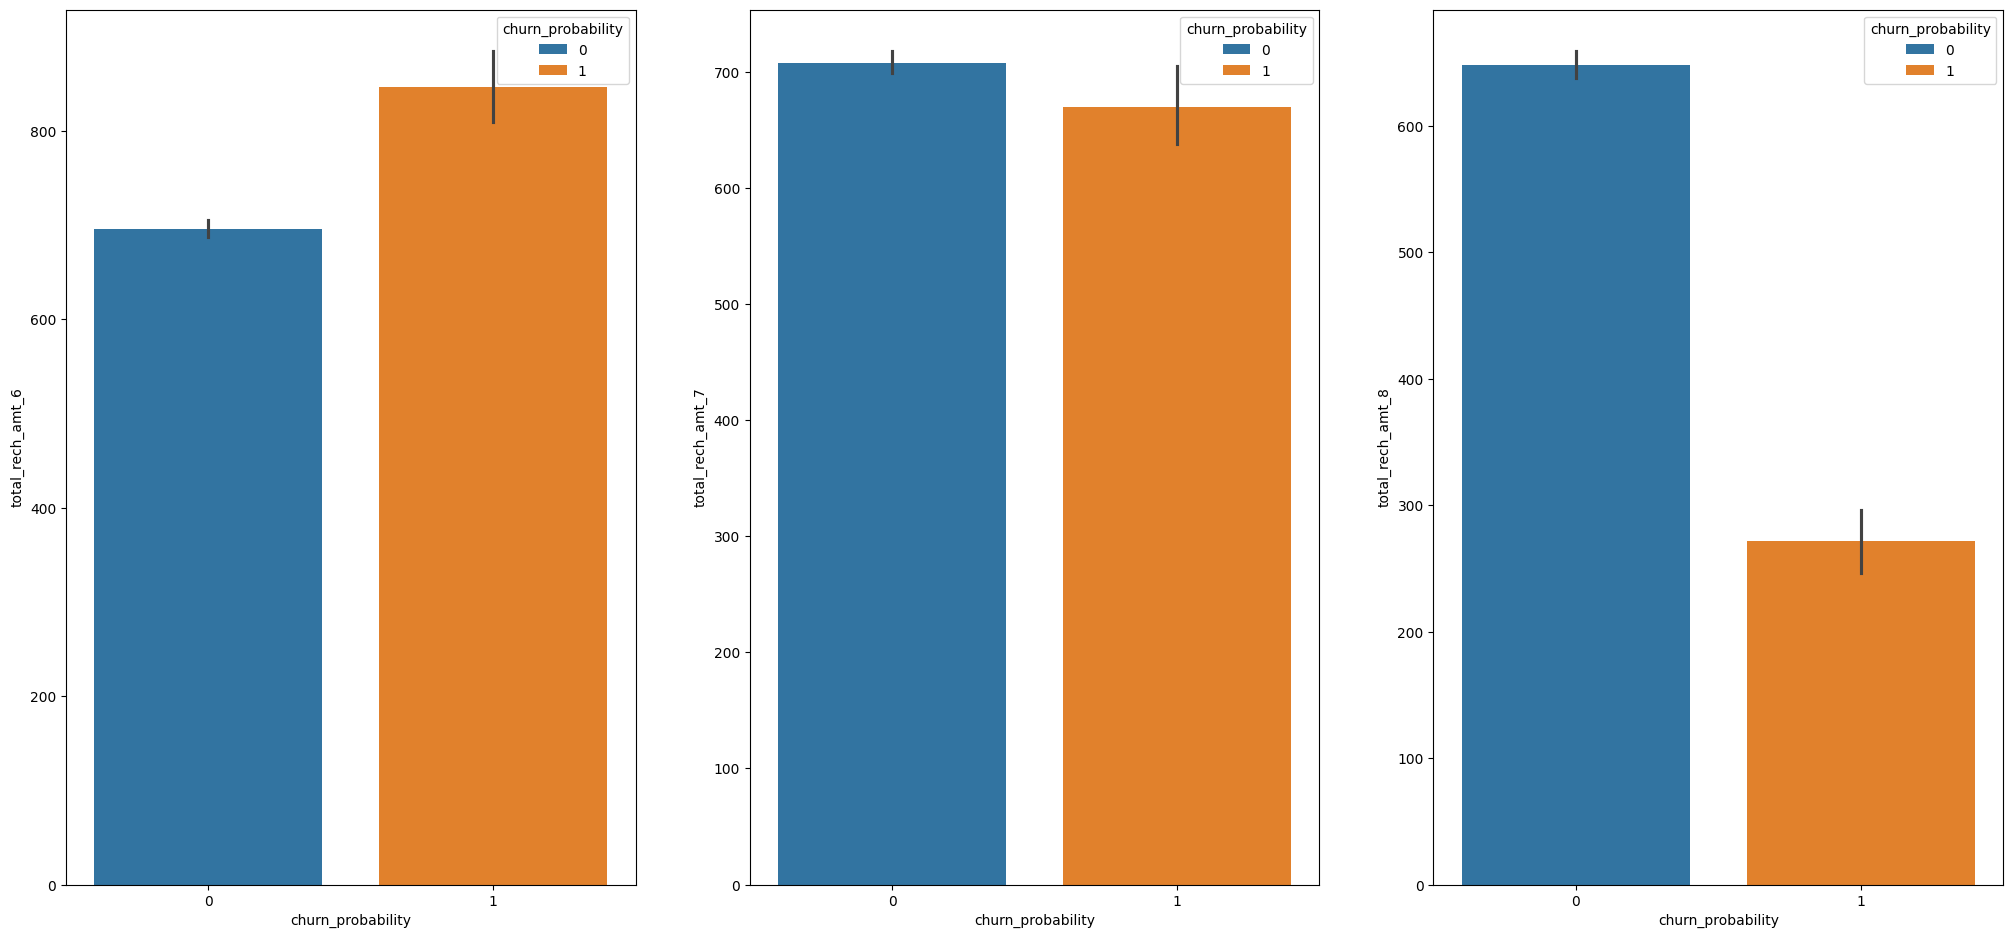

In [1053]:
plot_box_chart('total_rech_amt', high_value_telecom_df)

- The total recharge amount shows a steady decrease for **Churning** high valued customers. The decrease is more prominent in the **Action** month. 

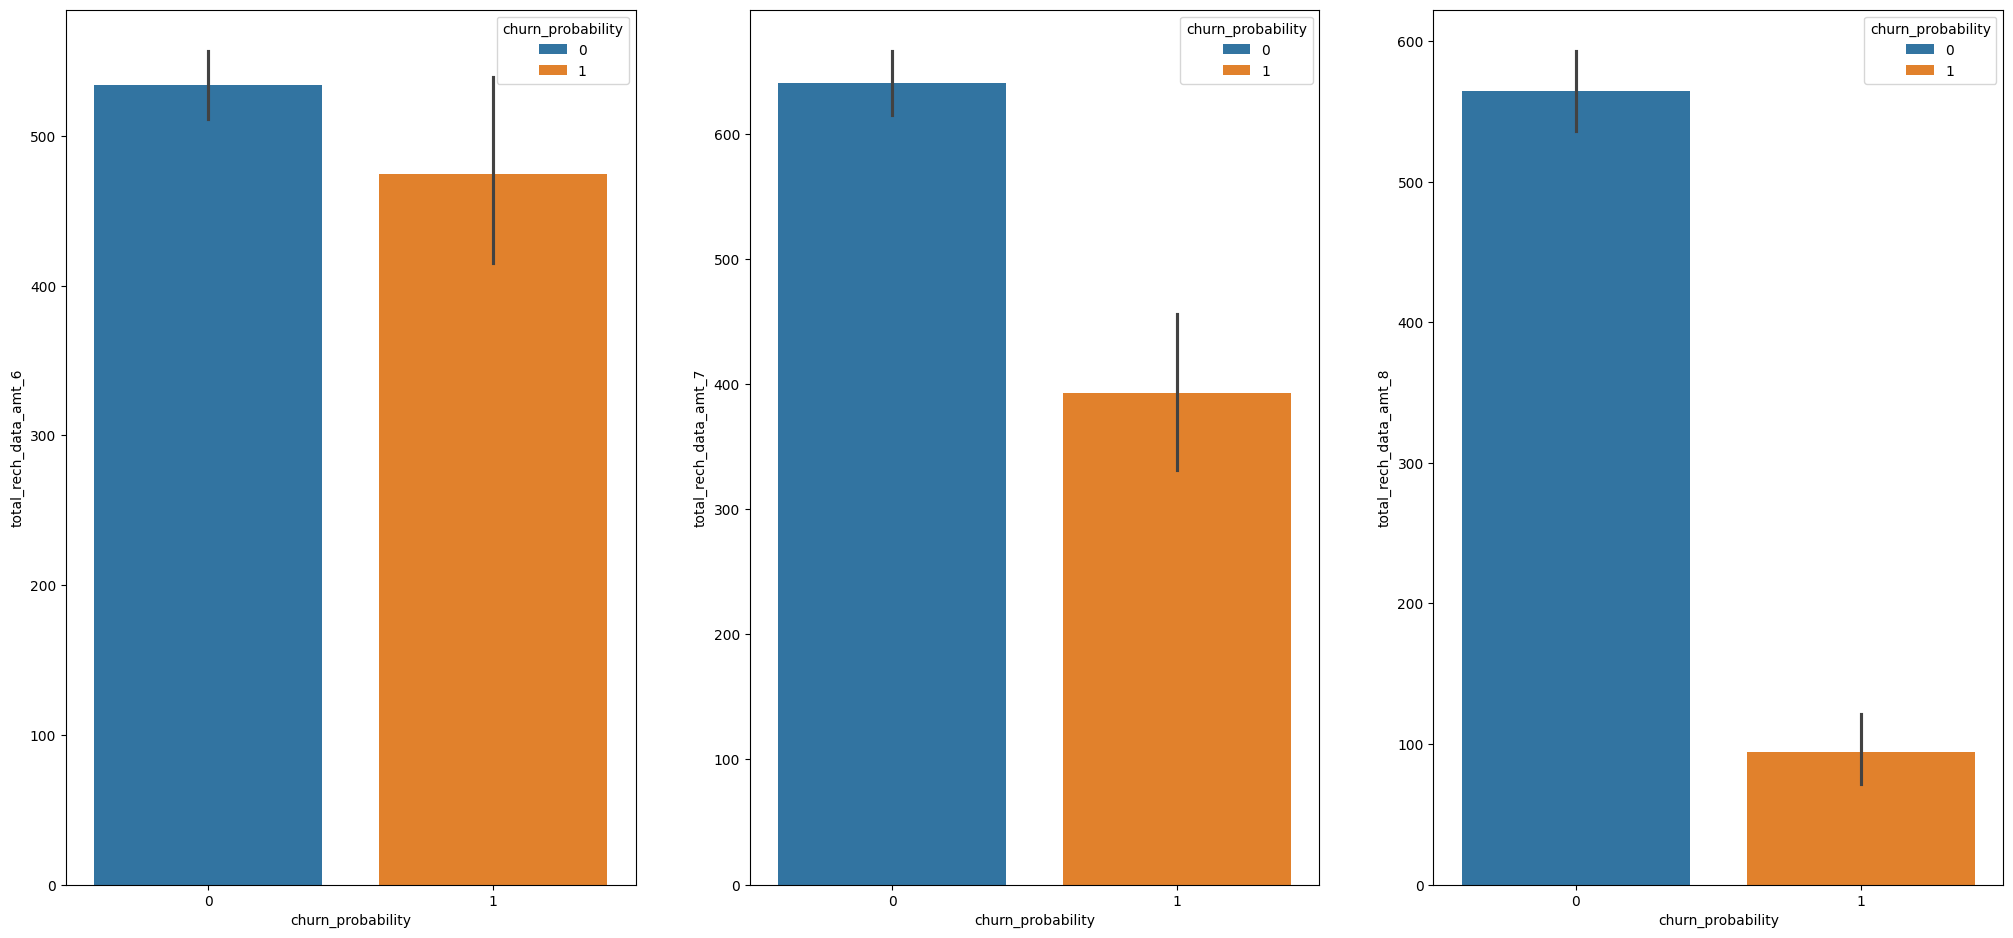

In [1054]:
plot_box_chart('total_rech_data_amt', high_value_telecom_df)

- The total **data** recharge amount shows a steady decrease for **Churning** high valued customers. The decrease is more prominent in the **Action** month. 

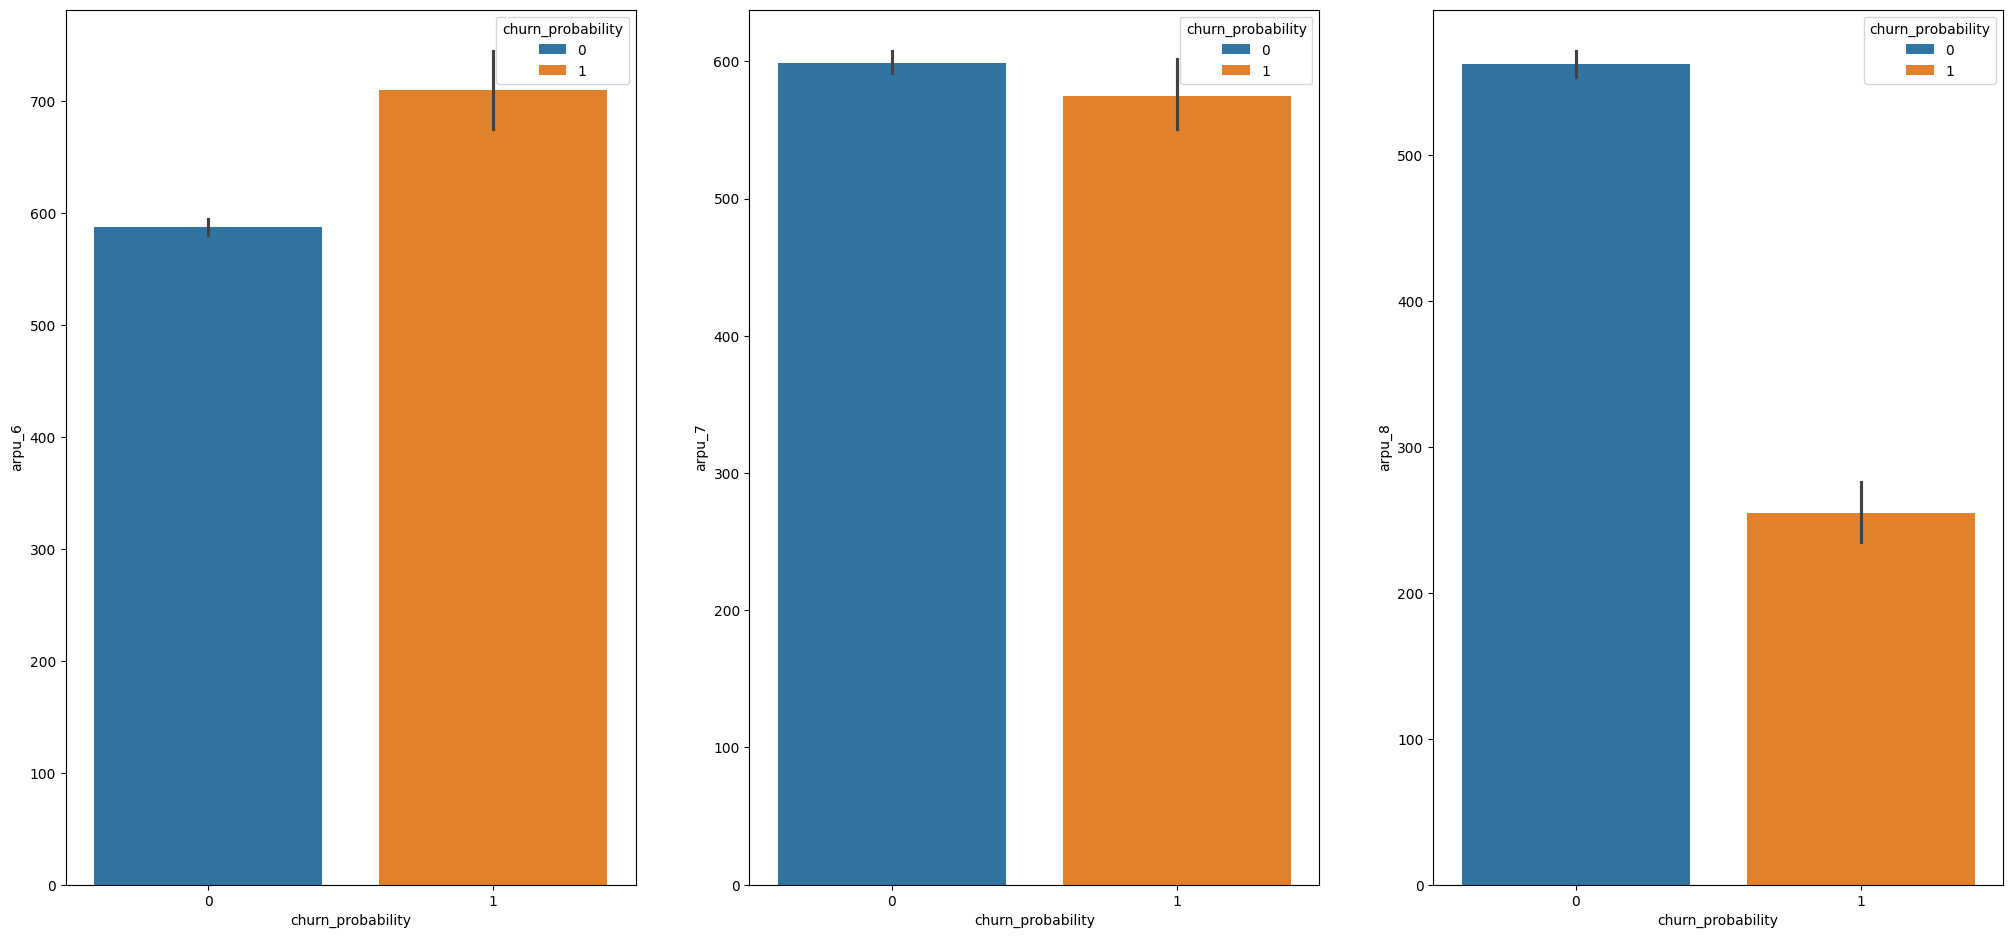

In [1055]:
plot_box_chart('arpu', high_value_telecom_df)

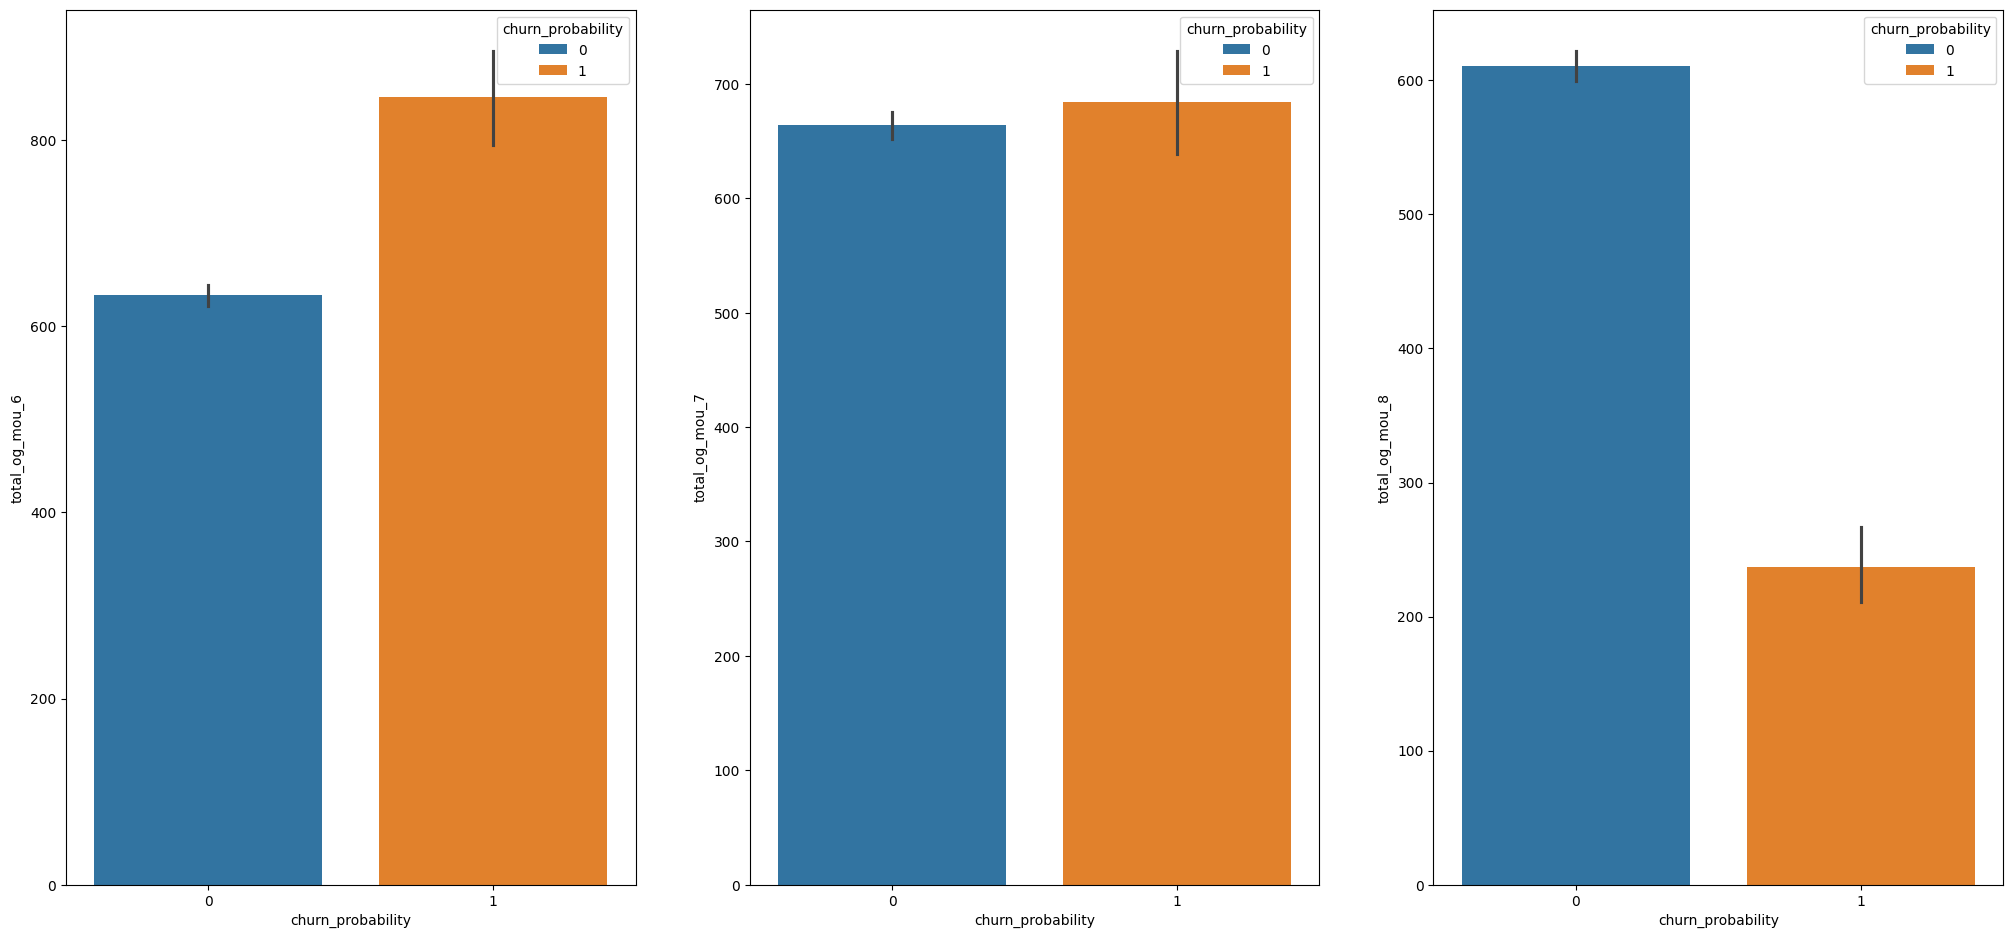

In [1056]:
plot_box_chart('total_og_mou', high_value_telecom_df)

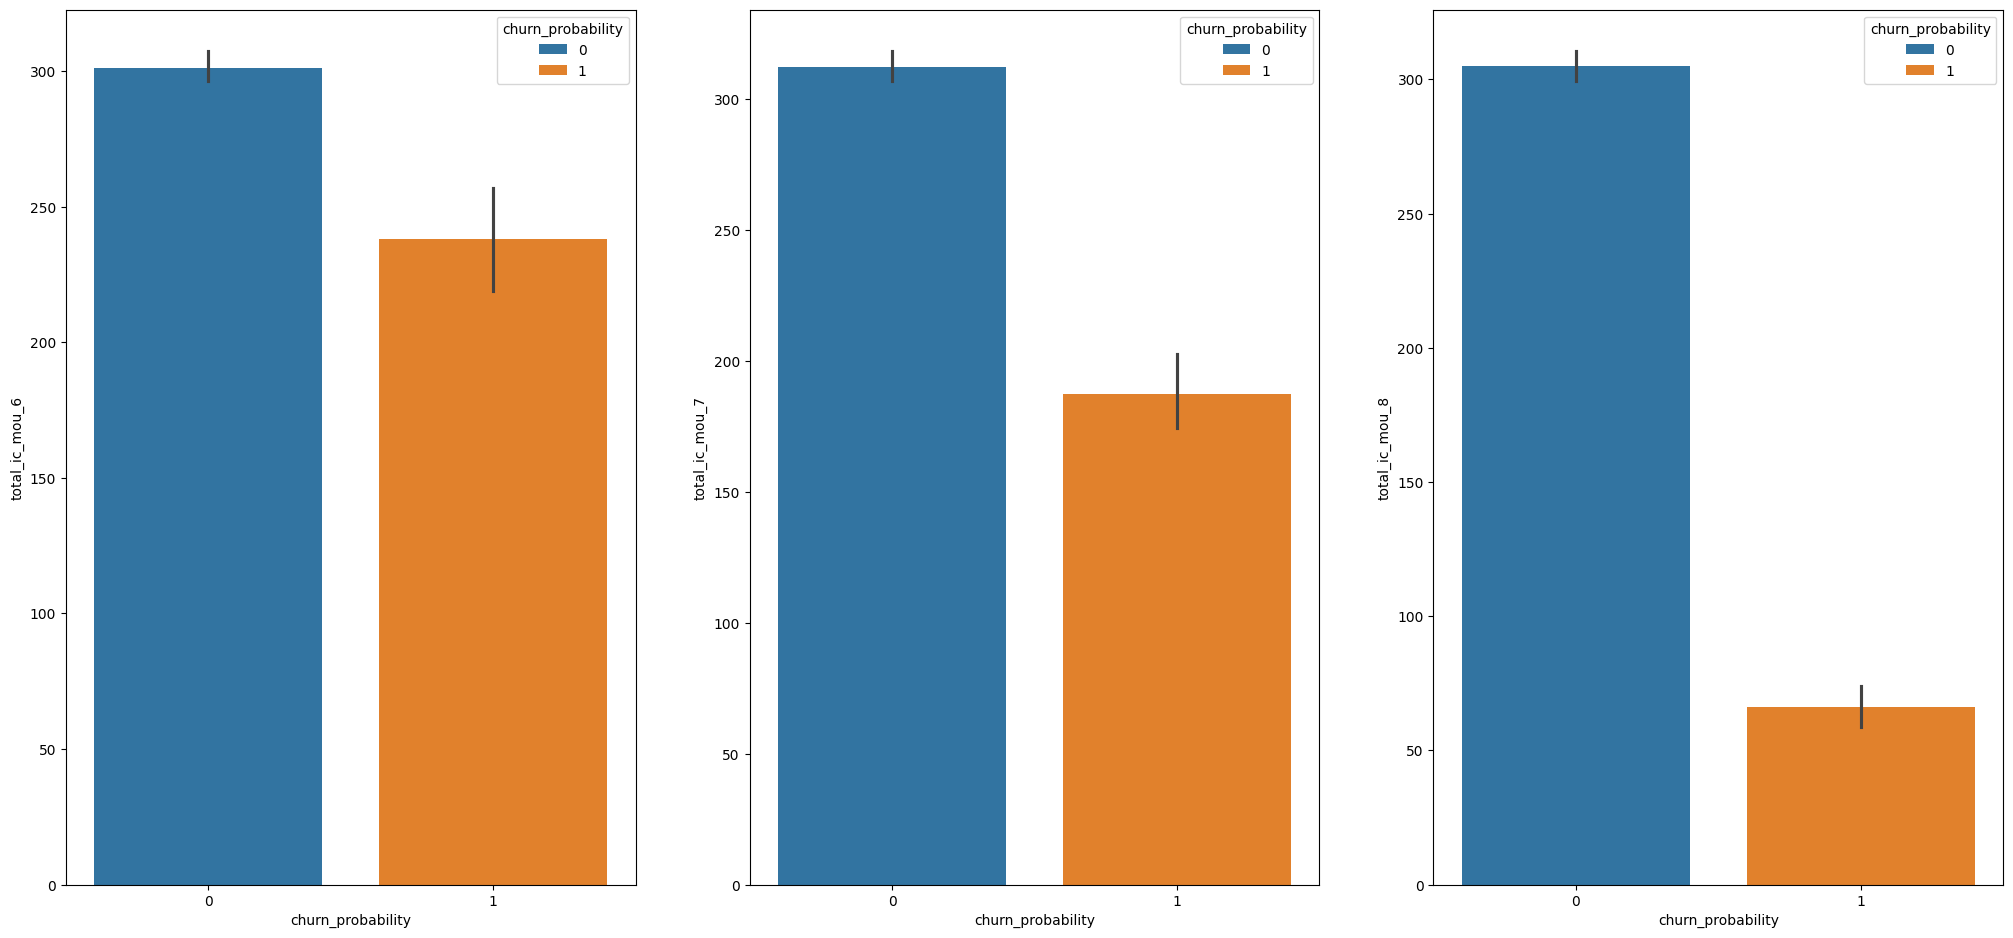

In [1057]:
plot_box_chart('total_ic_mou', high_value_telecom_df)

- The total incoming calls shows a steady decrease for **Churning** high valued customers.

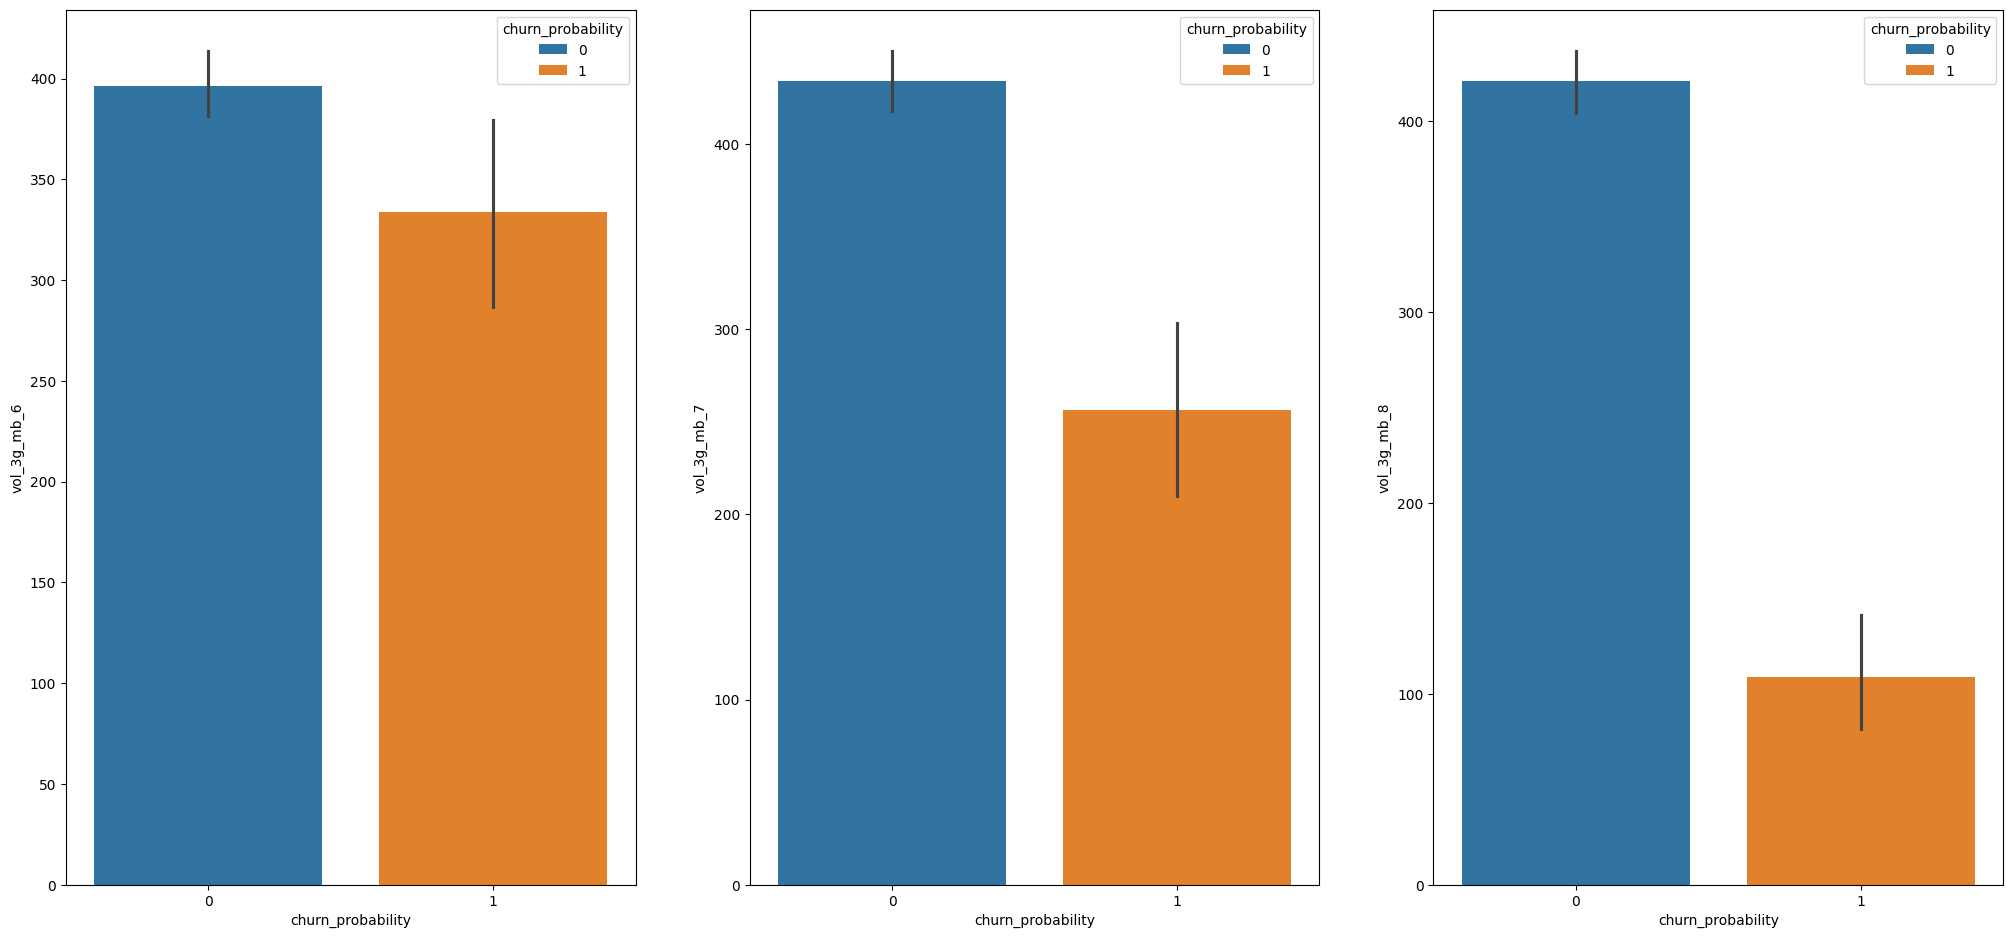

In [1058]:
plot_box_chart('vol_3g_mb', high_value_telecom_df)

- The 3G data usage shows a steady decrease for **Churning** high valued customers.

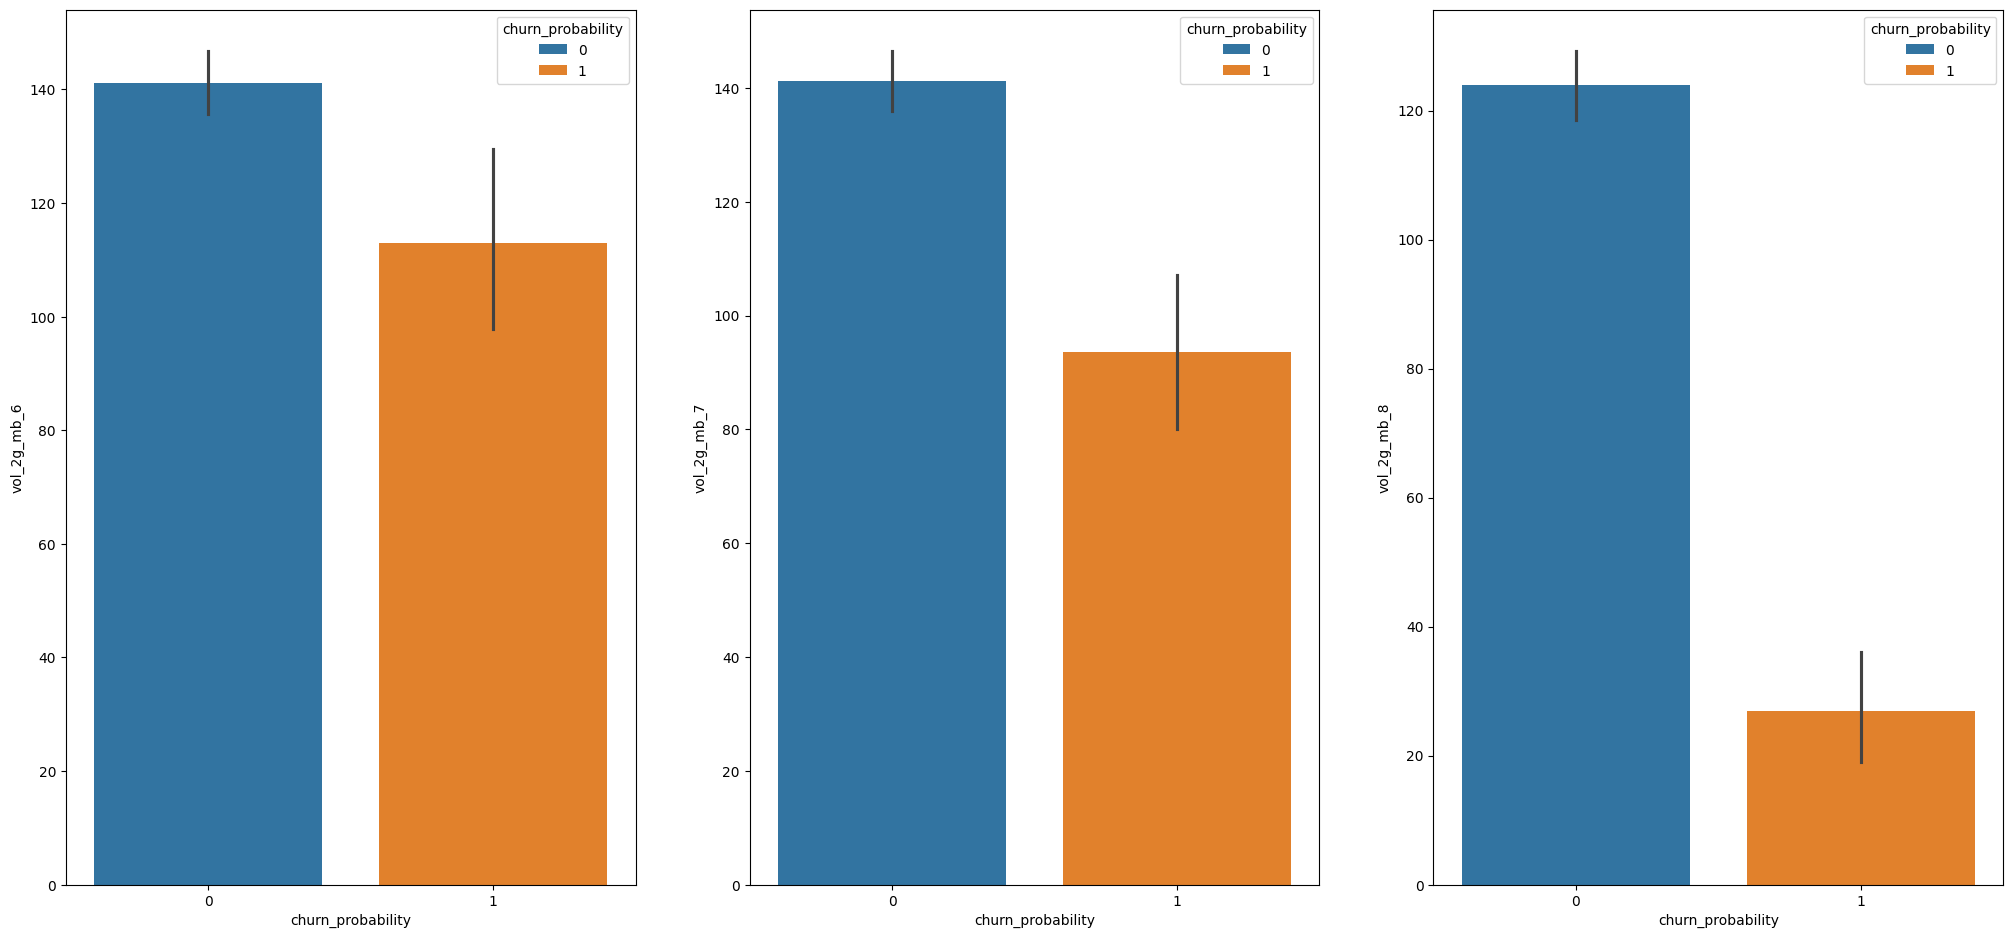

In [1059]:
plot_box_chart('vol_2g_mb', high_value_telecom_df)

- The 2G data usage shows a steady decrease for **Churning** high valued customers.

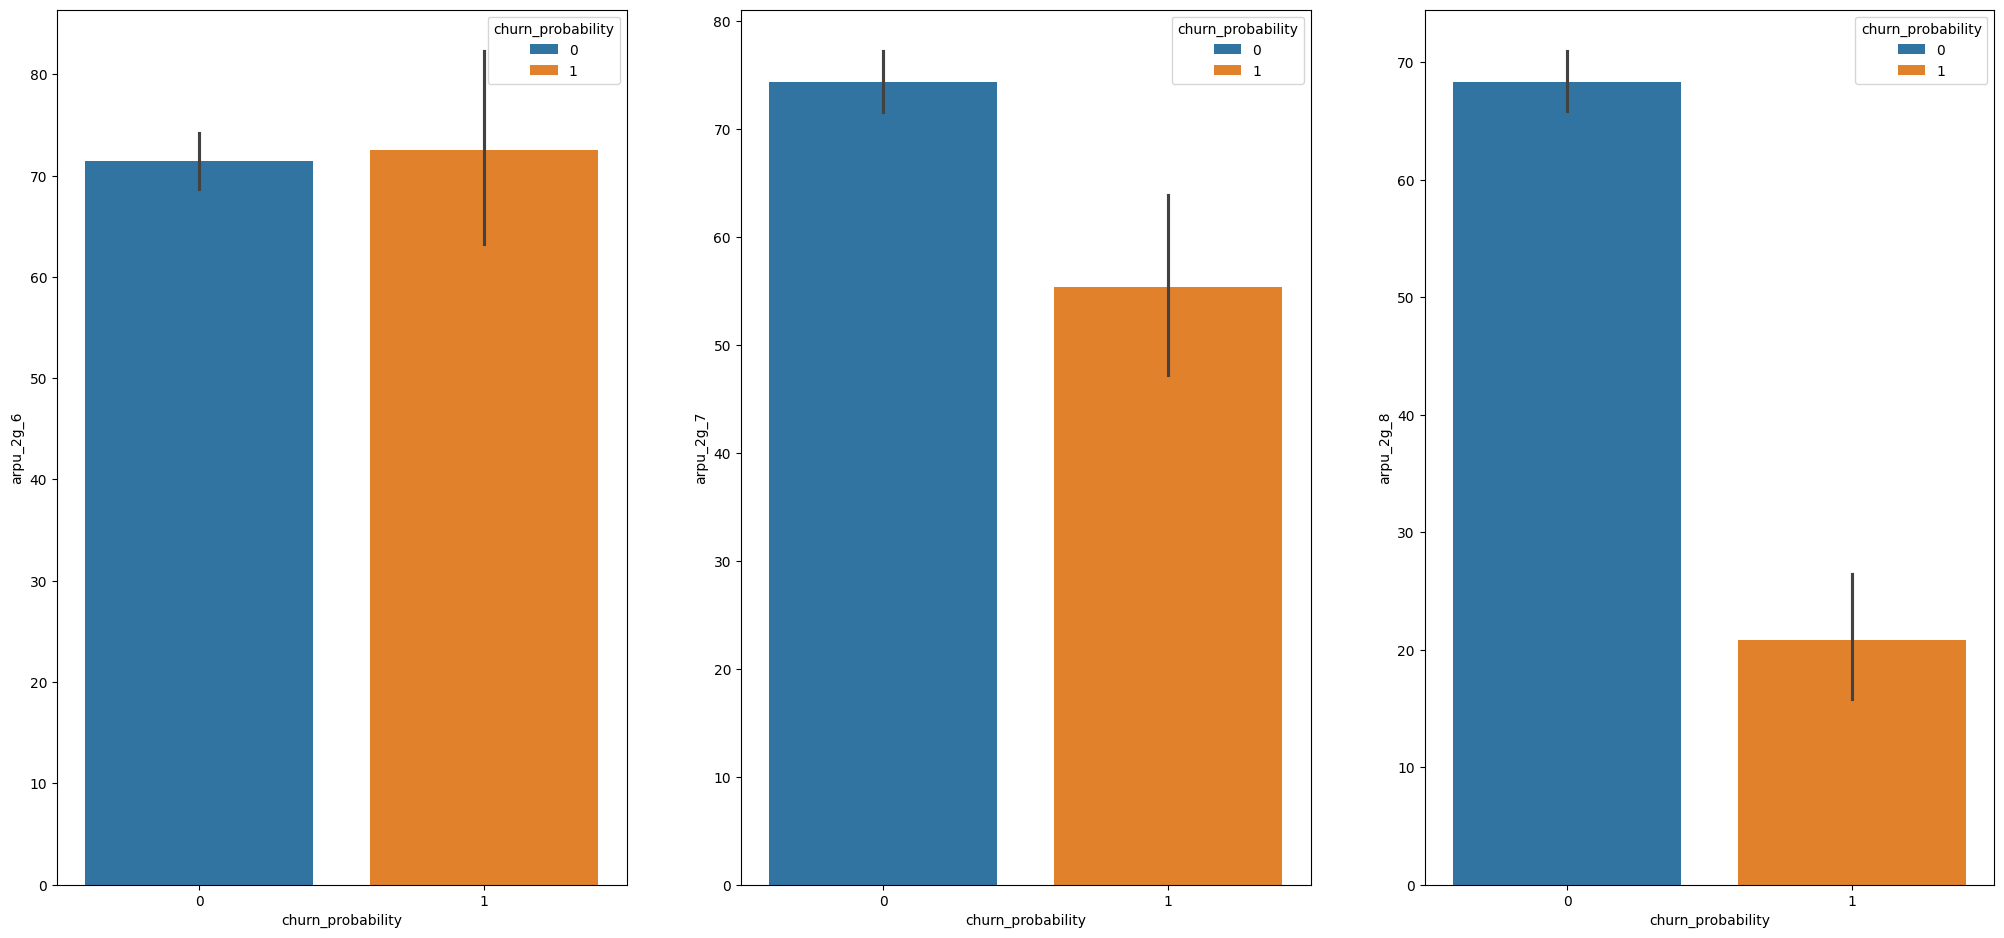

In [1060]:
plot_box_chart('arpu_2g', high_value_telecom_df)

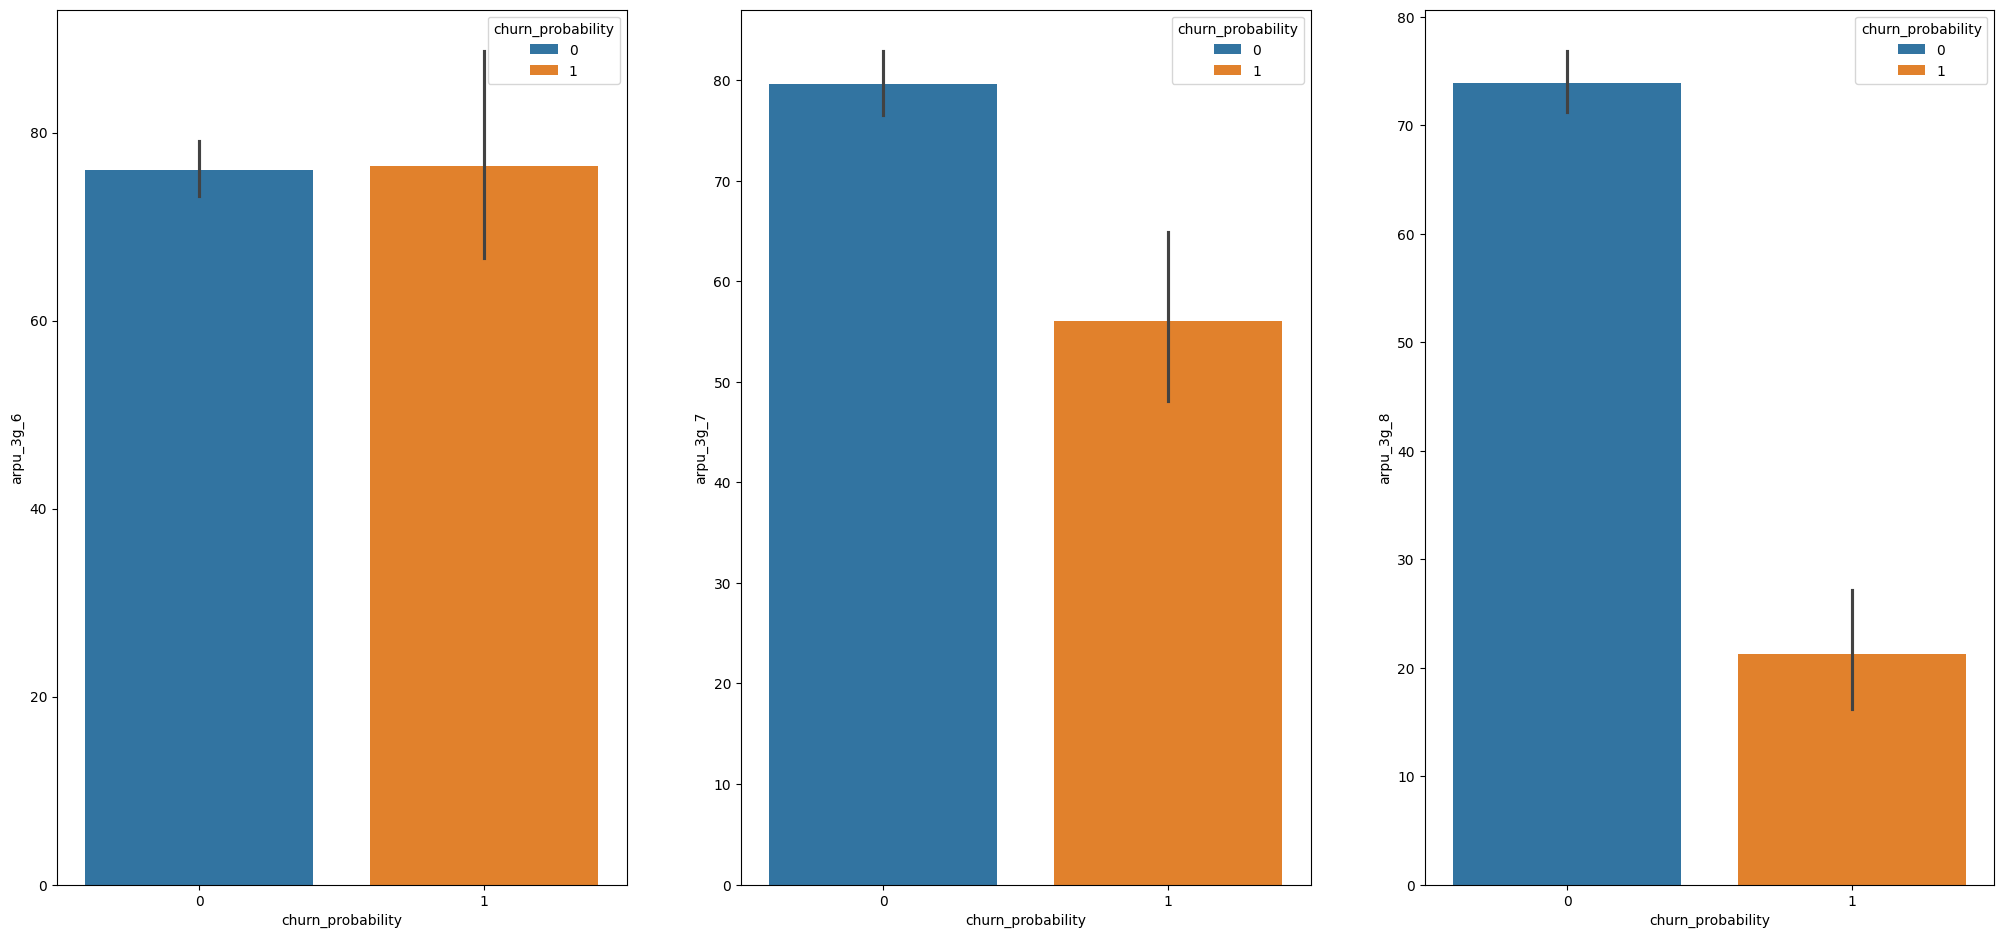

In [1061]:
plot_box_chart('arpu_3g', high_value_telecom_df)

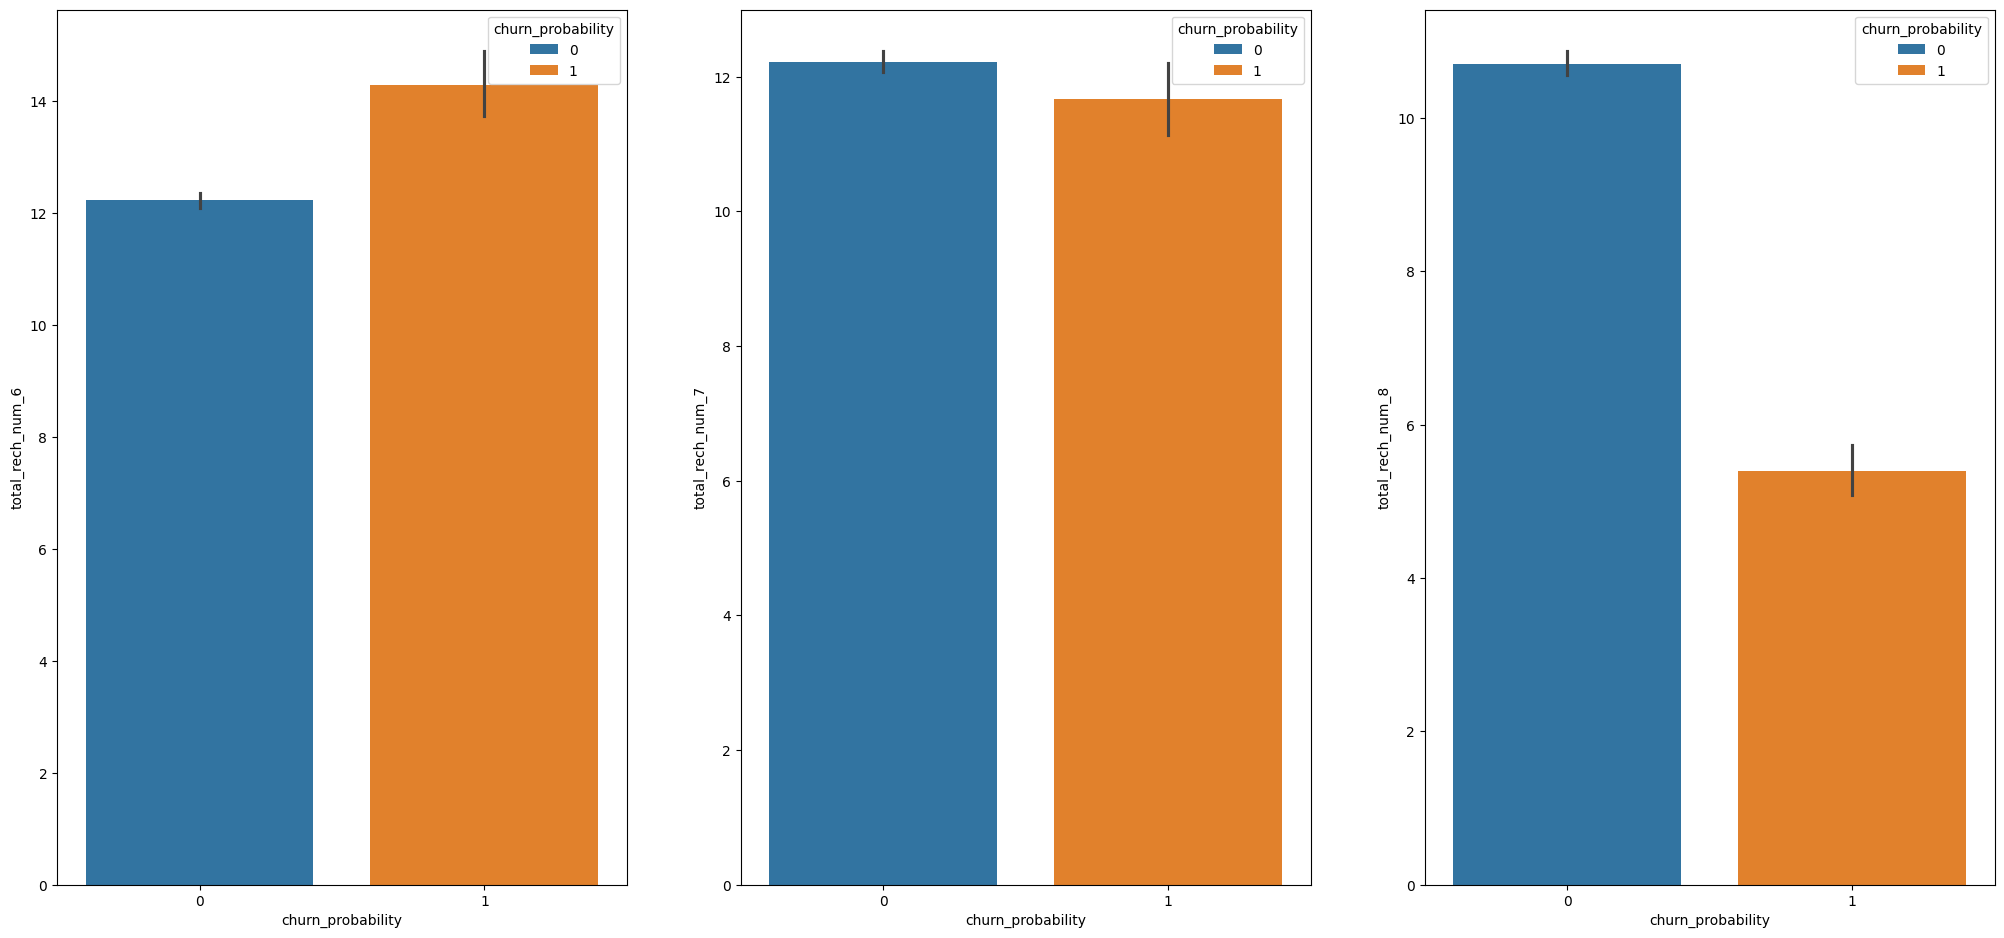

In [1062]:
plot_box_chart('total_rech_num', high_value_telecom_df)

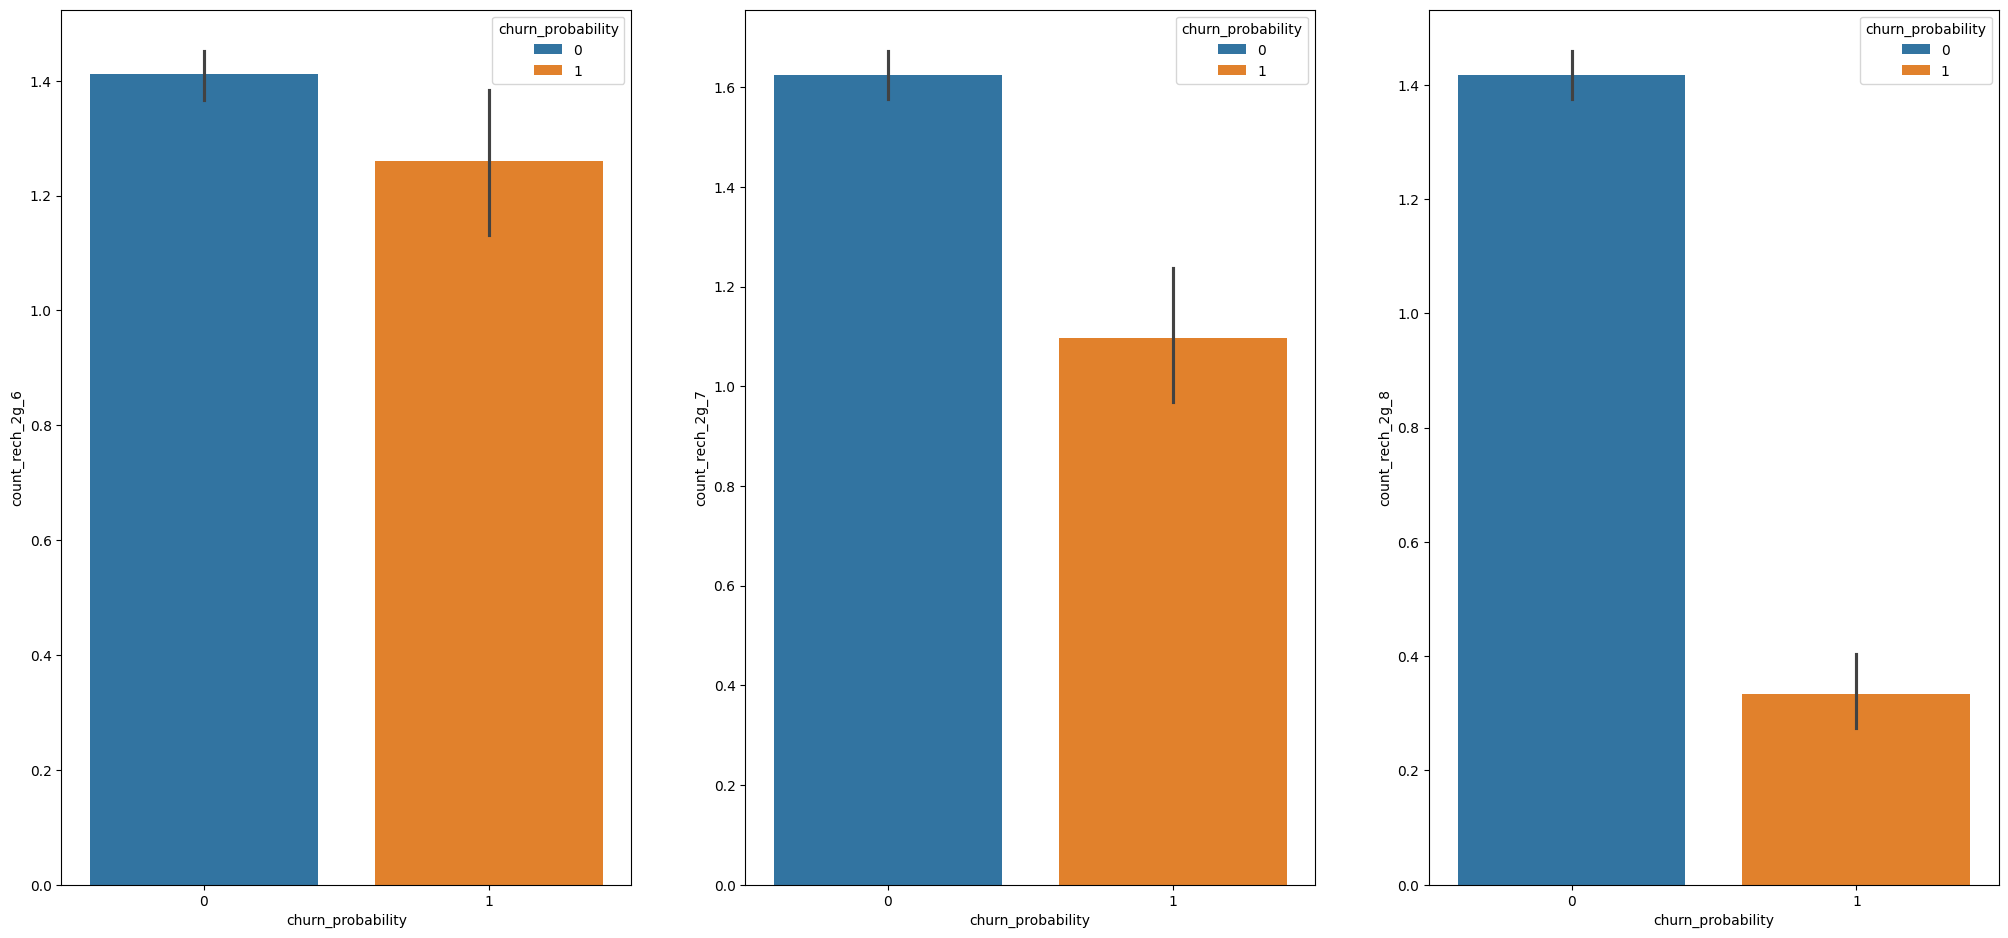

In [1063]:
plot_box_chart('count_rech_2g', high_value_telecom_df)

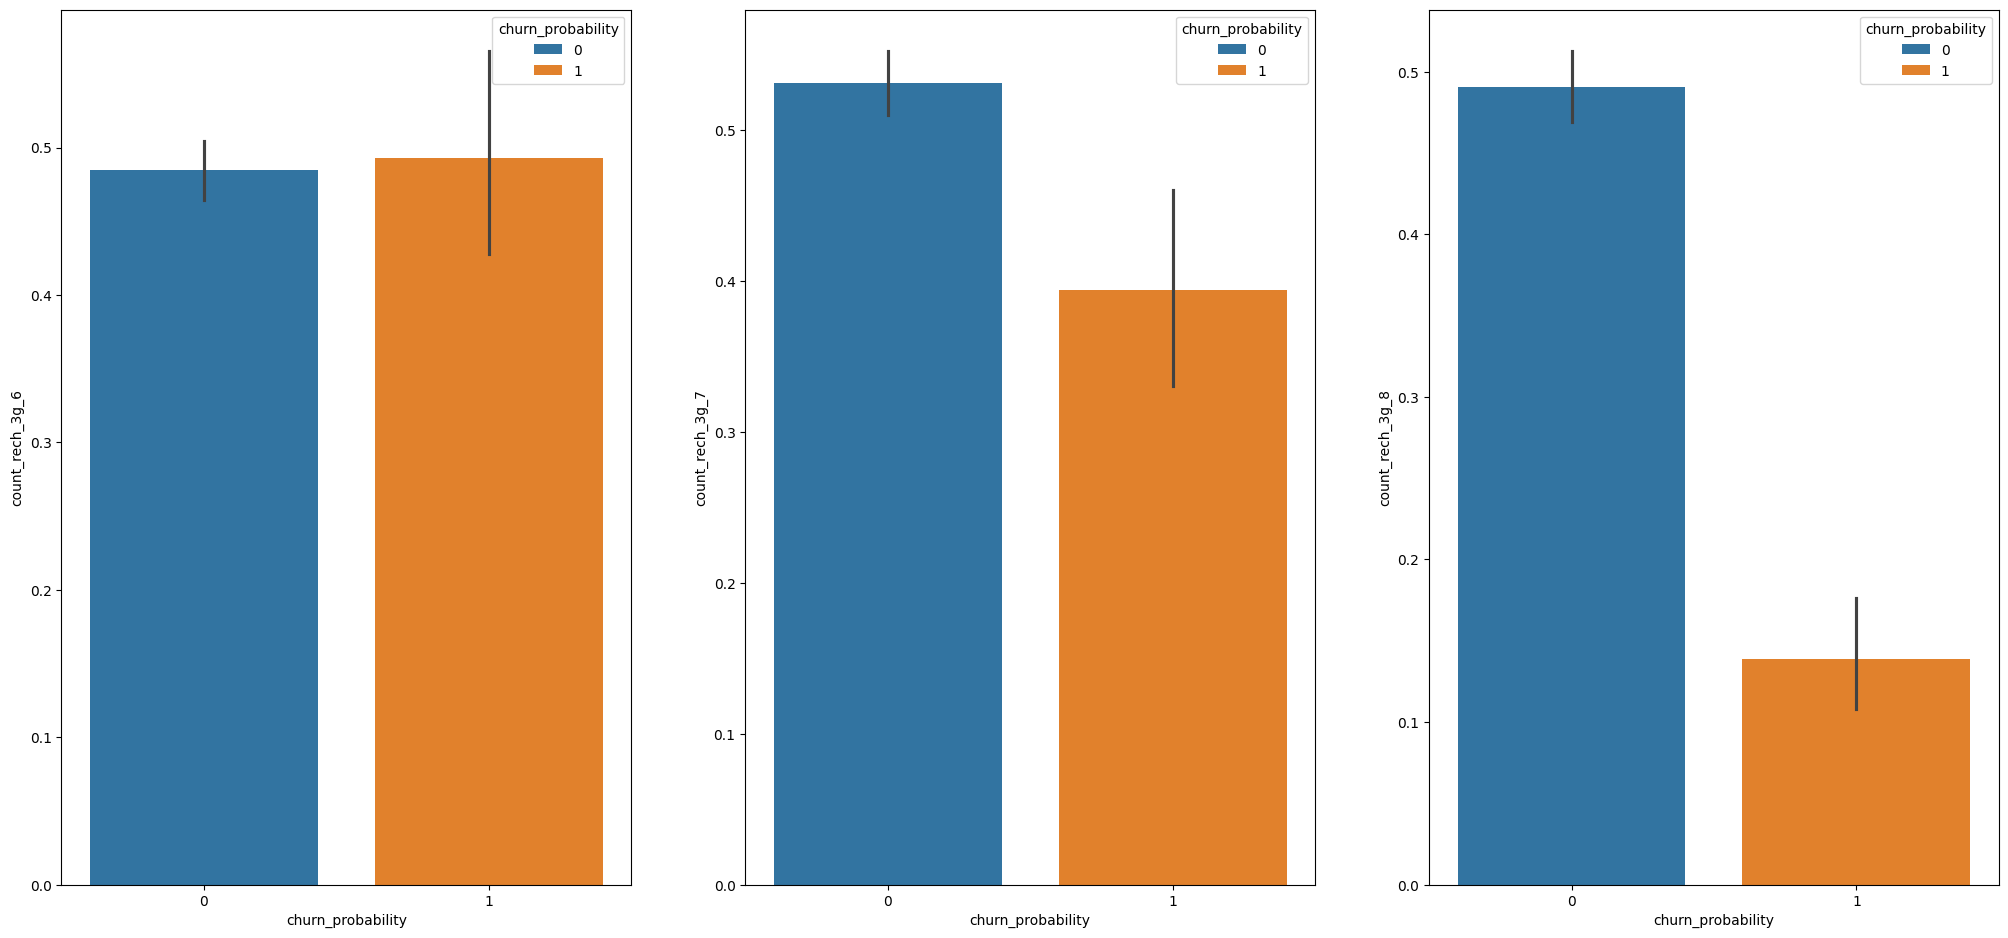

In [1064]:
plot_box_chart('count_rech_3g', high_value_telecom_df)

- The usage pattern oriented parameters showing the decreasing usage trend for churning customers are:
    - Decreasing Data Usage (both 2G and 3G)
    - Decreasing total incoming calls 
    - Decreasing total outgoing calls
- Sharp decline in these parameters shows decreasing interest from these customers driving the churn.

# 3. Model Building

## 3.1 Perform the Test Train Split

In [1065]:
print('Splitting the input values (X) and output value (y) from the Train Dataset.')
X = high_value_telecom_df.drop(['churn_probability'], axis=1)
y = high_value_telecom_df['churn_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

print('Splitting the ID column and the input values (X) from the Unseen Dataset.')
X_unseen = unseen_telecom_df
X_unseen_id = X_unseen.pop(('id'))

# Checking the shape after split
print('Train X Shape: ', X_train.shape)
print('Test X Shape: ', X_test.shape)
print('Unseen X Shape: ', X_unseen.shape)
print('Train y Shape: ', y_train.shape)
print('Test y Shape: ', y_test.shape)

Splitting the input values (X) and output value (y) from the Train Dataset.
Splitting the ID column and the input values (X) from the Unseen Dataset.
Train X Shape:  (13996, 164)
Test X Shape:  (3499, 164)
Unseen X Shape:  (30000, 164)
Train y Shape:  (13996,)
Test y Shape:  (3499,)


## 3.2 Handling the data imbalance for the **churn_probability** values using SMOTE.

In [1066]:
# smt = SMOTE(random_state=2)
# X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

# plt.figure(figsize=(10, 4))
# plt.subplot(1,2,1)
# plt.title("Distribution of churn (imbalanced)")
# sns.countplot(x=y_train, hue=y_train)

# plt.subplot(1,2,2)
# plt.title("Distribution of churn (balanced)")
# sns.countplot(x=y_train_smote, hue=y_train_smote)

# plt.show()

# X_train = X_train_smote
# y_train = y_train_smote

## 3.3 Perform the scaling using MinMax Scaler

In [1067]:
print('Performing scaling on the Train, Test and Unseen data using MinMaxScaler')
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_unseen_scaled = scaler.transform(X_unseen)

X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_unseen = pd.DataFrame(X_unseen_scaled, columns = X_unseen.columns)

Performing scaling on the Train, Test and Unseen data using MinMaxScaler


## 3.4 Perform the PCA to determine the optimum size of features

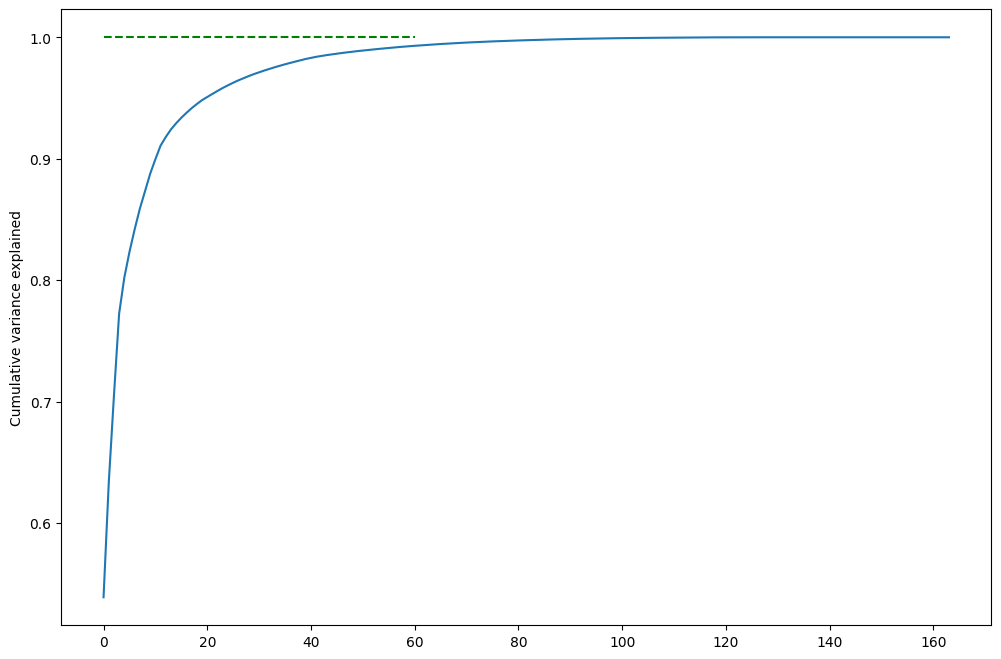

In [1068]:
pca = PCA(random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=[12,8])
plt.hlines(y=1.00, xmax=60, xmin=0, colors="g", linestyles="--")
plt.plot(cumulative_variance_ratio)
plt.ylabel("Cumulative variance explained")
plt.show()

- PCA reduces the dimensionality of the dataset with 90% of the variance explained by ~12 input parameters.
- We will consider **25 parameters** for carrying out our Analysis which is a significant reduction from the original column size of **170 parameters**

## 3.5 Transform the Test/Train Dataset with the PCA and the optimum size of feature.

In [1069]:
pca = PCA(n_components = 25)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_unseen_pca = pca.transform(X_unseen)
print('Shape of Training Set: ', X_train_pca.shape)
print('Shape of Test Set: ', X_test_pca.shape)
print('Shape of Unseen Set: ', X_unseen_pca.shape)

Shape of Training Set:  (13996, 25)
Shape of Test Set:  (3499, 25)
Shape of Unseen Set:  (30000, 25)


- PCA Fit Train Set  - **X_train_pca**
- PCA Fit Test Set   - **X_test_pca**
- PCA Fit Unseen Set - **X_unseen_pca**

## 3.6 Perform Learning using multiple models using PCA
  - Logistic Regression
  - Decision Tree Classifier
  - Decision Tree Classifier using GridCV
  - Adaboost Classifier
  - Random Forest Classifier using GridCV
  - XGBoost Classifier

In [1070]:
def print_result(y_train, y_train_pred, y_test, y_test_pred):
    result = [
        [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
        [precision_score(y_train, y_train_pred),precision_score(y_test, y_test_pred)],
        [recall_score(y_train, y_train_pred),recall_score(y_test, y_test_pred) ]
    ]

    result_df = pd.DataFrame(result, columns=['Train', 'Test'])
    result_df.index = ['Accuracy', 'Precision', 'Recall']
    print(result_df)

#### 3.4.1.1 Perform Logistic Regression on the PCA transformed Test/Train Dataset

              Train      Test
Accuracy   0.919120  0.921120
Precision  0.581818  0.468750
Recall     0.055652  0.054745


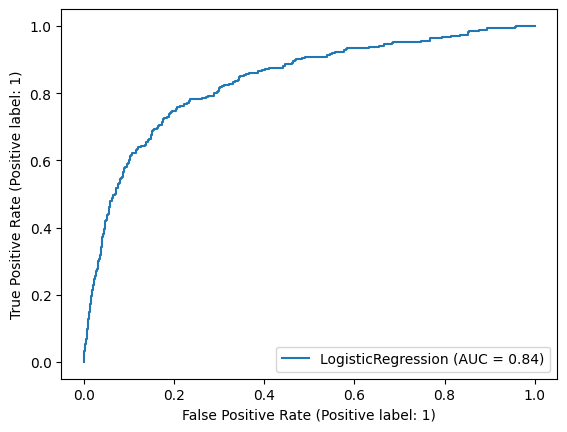

In [1071]:
logistic_regression = LogisticRegression()
rfe_selector = RFE(logistic_regression, n_features_to_select = 25)
rfe_selector.fit(X_train_pca, y_train)

logistic_regression.fit(X_train_pca, y_train)
y_train_pca_pred = logistic_regression.predict(X_train_pca)
y_test_pca_pred = logistic_regression.predict(X_test_pca)
print_result(y_train, y_train_pca_pred, y_test, y_test_pca_pred)
logistic_regression_pca_auc = RocCurveDisplay.from_estimator(logistic_regression, X_test_pca, y_test)

#### 3.4.1.2 Perform Logistic Regression on the PCA transformed unseen dataset.

In [1072]:
y_unseen_pca_pred = logistic_regression.predict(X_unseen_pca)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_pca_pred})
output_df.to_csv('outputs/withpca/lr_pca.csv',index=False)

- Accuracy on the training and testing set is comparable. However, the recall value is significantly less indicating that the model is not effectively identifying all the relevant positive instances in a dataset.

#### 3.4.2.1 Perform Logistic Regression using Decision Tree Classifier on the PCA transformed Test/Train Dataset

           Train      Test
Accuracy     1.0  0.888825
Precision    1.0  0.307692
Recall       1.0  0.335766


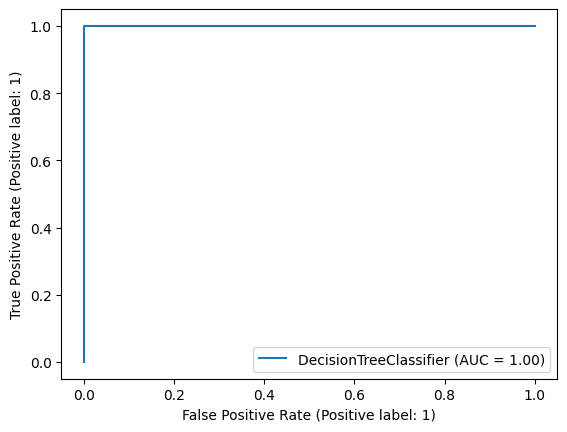

In [1073]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train_pca, y_train)
y_train_pca_dtc_pred = decision_tree_classifier.predict(X_train_pca)
y_test_pca_dtc_pred = decision_tree_classifier.predict(X_test_pca)
print_result(y_train, y_train_pca_dtc_pred, y_test, y_test_pca_dtc_pred)
decision_tree_classifer_auc = RocCurveDisplay.from_estimator(decision_tree_classifier, X_train_pca, y_train_pca_dtc_pred)

- Accuracy on the training and testing set is comparable. However, the precision value is significantly less in the **Test** data indicating that the model is incorrectly generating a high number of FALSE Positives.

#### 3.4.2.2 Perform Logistic Regression using Decision Tree Classifier on the PCA transformed unseen dataset.

In [1074]:
y_unseen_pca_dtc_pred = decision_tree_classifier.predict(X_unseen_pca)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_pca_dtc_pred})
output_df.to_csv('outputs/withpca/dtc_pca.csv',index=False)

#### 3.4.3.1 Perform Logistic Regression using Decision Tree Classifier with GridCV on the PCA transformed Test/Train dataset.

Fitting 5 folds for each of 50 candidates, totalling 250 fits
              Train      Test
Accuracy   0.923621  0.925979
Precision  0.731429  0.682927
Recall     0.111304  0.102190


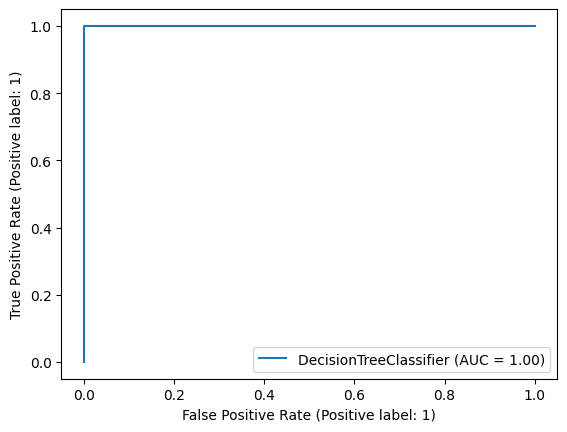

In [1075]:
decision_tree_classifier_gridcv = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search_classifier = GridSearchCV(estimator = decision_tree_classifier_gridcv, 
                           param_grid = params, 
                           cv = 5, n_jobs = -1, verbose = 1, scoring = "accuracy")

grid_search_classifier.fit(X_train_pca, y_train)
grid_search_model = grid_search_classifier.best_estimator_
y_train_pca_dtcgridcv_pred = grid_search_model.predict(X_train_pca)
y_test_pca_dtcgridcv_pred = grid_search_model.predict(X_test_pca)
print_result(y_train, y_train_pca_dtcgridcv_pred, y_test, y_test_pca_dtcgridcv_pred)
decision_tree_classifer_gridcv_auc = RocCurveDisplay.from_estimator(grid_search_model, X_test_pca, y_test_pca_dtcgridcv_pred)

#### 3.4.3.2 Perform Logistic Regression using Decision Tree Classifier with GridCV on the PCA transformed unseen dataset.

In [1076]:
y_unseen_pca_dtcgridcv_pred = grid_search_model.predict(X_unseen_pca)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_pca_dtcgridcv_pred})
output_df.to_csv('outputs/withpca/dtcgridcv_pca.csv',index=False)

- Accuracy on the training and testing set is comparable. However, as with Linear Regression the recall value is significantly less indicating that the model is not effectively identifying all the relevant positive instances in a dataset.

#### 3.4.4.1 Perform Logistic Regression using Adaboost Classifier on the PCA transformed Test/Train dataset.

              Train      Test
Accuracy   0.926265  0.921120
Precision  0.628261  0.491525
Recall     0.251304  0.211679


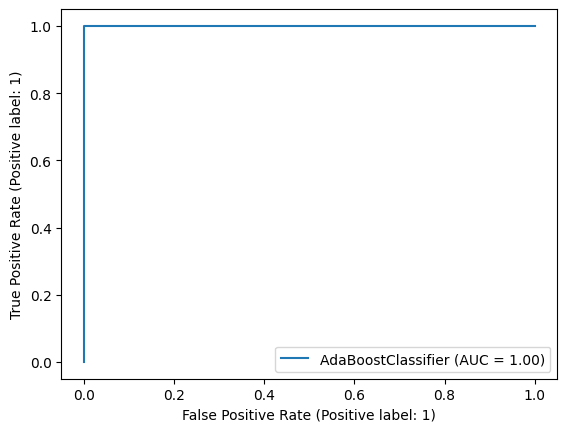

In [1077]:
adaboost_classifier = AdaBoostClassifier(n_estimators=200, random_state=1)

adaboost_classifier.fit(X_train_pca, y_train)
y_train_pca_adaboost_pred = adaboost_classifier.predict(X_train_pca)
y_test_pca_adaboost_pred = adaboost_classifier.predict(X_test_pca)
print_result(y_train, y_train_pca_adaboost_pred, y_test, y_test_pca_adaboost_pred)
adaboost_classifier_auc = RocCurveDisplay.from_estimator(adaboost_classifier, X_test_pca, y_test_pca_adaboost_pred)

#### 3.4.4.2 Perform Logistic Regression using Adaboost Classifier on the PCA transformed unseen dataset.

In [1078]:
y_unseen_pca_adaboost_pred = adaboost_classifier.predict(X_unseen_pca)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_pca_adaboost_pred})
output_df.to_csv('outputs/withpca/adaboost_pca.csv',index=False)

- Accuracy on the training and testing set is comparable. 
- Precision is also comparable in the training and testing set.
- Recall value is still small across both the training and testing set indicating model being unable to determine the **True** Positives.

#### 3.4.5.1 Perform Logistic Regression using Random Forest on the PCA transformed Test/Train dataset.


Fitting 4 folds for each of 144 candidates, totalling 576 fits
              Train      Test
Accuracy   0.952915  0.925979
Precision  0.995960  0.682927
Recall     0.428696  0.102190


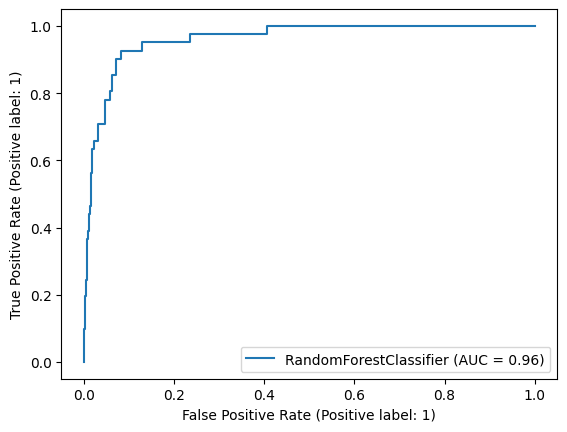

In [1079]:
random_forest_gridcv_classifier = RandomForestClassifier(n_estimators = 10, max_depth = 4, max_features = 5, random_state = 100)
params = {
    'max_depth': [2, 3, 5, 10 , 20, 50],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'n_estimators': [10, 25, 50, 100]
}
random_forest_gridcv_classifier = GridSearchCV(estimator = random_forest_gridcv_classifier, 
                                      param_grid = params, 
                                      cv = 4, 
                                      n_jobs = -1, 
                                      verbose = 1, 
                                      scoring = "accuracy")

random_forest_gridcv_classifier.fit(X_train_pca, y_train)
random_forest_model = random_forest_gridcv_classifier.best_estimator_

y_train_pca_randomforestgridcv_pred = random_forest_model.predict(X_train_pca)
y_test_pca_randomforestgridcv_pred = grid_search_model.predict(X_test_pca)
print_result(y_train, y_train_pca_randomforestgridcv_pred, y_test, y_test_pca_randomforestgridcv_pred)
decision_tree_classifer_gridcv_auc = RocCurveDisplay.from_estimator(random_forest_model, X_test_pca, y_test_pca_randomforestgridcv_pred)

#### 3.4.5.2 Perform Logistic Regression using Random Forest on the PCA transformed unseen dataset.

In [1080]:
y_train_pca_randomforestgridcv_pred = random_forest_model.predict(X_unseen_pca)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_train_pca_randomforestgridcv_pred})
output_df.to_csv('outputs/withpca/randomforest_pca.csv',index=False)

- Accuracy on the training and testing set is comparable. 
- Precision is quite high in the training set while lagging in the testing set.
- Recall value improved in the training set. However, still stays low in the testing set indicating model being unable to determine the **True** Positives.

#### 3.4.6.1 Perform Logistic Regression using XGBoost on the PCA transformed Test/Train dataset.

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.940 total time=   0.5s
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.937 total time=   0.5s
[CV 5/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.945 total time=   0.5s
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.945 total time=   0.5s
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.943 total time=   0.6s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.25, max_depth=10, n_estimators=25, scale_pos_weight=1, subsam

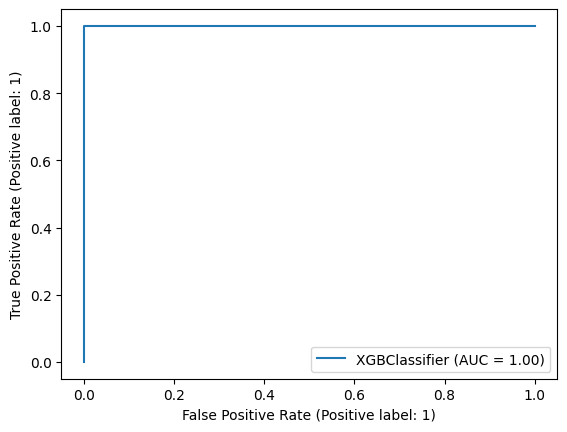

In [1081]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [10, 25, 50, 100],
    'max_depth': [2, 3, 5, 10 ,20, 50],
    'scale_pos_weight': [1],
    'gamma': [0.1, 0.5, 1, 1.5, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
}

folds = 5

param_comb = 800

xgboost_classifier = xgb.XGBClassifier(n_jobs = -1, objective = 'binary:logistic') # default paramters
#xgboost_gridcv_classifier = GridSearchCV(estimator = xgboost_classifier, param_grid = param_grid, cv = 5, scoring='accuracy', n_jobs = -1)
xgboost_gridcv_classifier = RandomizedSearchCV(xgboost_classifier, param_distributions=params, n_iter=param_comb, verbose=3, scoring='accuracy', n_jobs = -1, cv = 5, random_state=42)
xgboost_gridcv_classifier.fit(X_train, y_train)

xgboost_model = xgboost_gridcv_classifier.best_estimator_
xgboost_model.fit(X_train_pca, y_train)
y_train_pca_xgb_pred = xgboost_model.predict(X_train_pca)
y_test_pred_xgb_pred = xgboost_model.predict(X_test_pca)
print_result(y_train, y_train_pca_xgb_pred, y_test, y_test_pred_xgb_pred)
xgb_classifier_auc = RocCurveDisplay.from_estimator(xgboost_model, X_test_pca, y_test_pred_xgb_pred)

#### 3.4.6.2 Perform Logistic Regression using XGBoost on the PCA transformed unseen dataset.

In [1082]:
y_unseen_pca_xgboost_pred = xgboost_model.predict(X_unseen_pca)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_pca_xgboost_pred})
output_df.to_csv('outputs/withpca/xgboost_pca.csv',index=False)

- Accuracy on the training and testing set is comparable. [BEST]
- Precision is quite high in the training set while lagging in the testing set. [BEST]
- Recall value improved in the training set. However, still stays low in the testing set indicating model being unable to determine the **True** Positives.

**Overall, the XGBoost model seems to be doing decent in terms of the various metrics.**

## 3.7 Perform Learning using multiple models without PCA

#### 3.5.1.1 Perform Logistic Regression on the Test/Train Dataset

In [1083]:
logistic_regression = LogisticRegression()

rfe_selector = RFE(logistic_regression, n_features_to_select = 20)
rfe_selector.fit(X_train, y_train)

selected_features = X_train.columns[rfe_selector.support_]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_unseen_selected = X_unseen[selected_features]

logistic_regression.fit(X_train_selected, y_train)

y_train_pred = logistic_regression.predict(X_train_selected)
y_test_pred = logistic_regression.predict(X_test_selected)

print_result(y_train, y_train_pred, y_test, y_test_pred)

              Train      Test
Accuracy   0.919120  0.923692
Precision  0.609756  0.652174
Recall     0.043478  0.054745


#### 3.5.1.2 Perform Logistic Regression on the unseen dataset.

In [1084]:
y_unseen_pred = logistic_regression.predict(X_unseen_selected)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_pred})
output_df.to_csv('outputs/withoutpca/lr.csv',index=False)

- Accuracy on the training and testing set is comparable. 
- Precision is also comparable in the training and testing set but remains low across both.
- Recall value is very very small across both the training and testing set indicating model being unable to determine the **True** Positives.

#### 3.5.2.1 Perform Logistic Regression using Decision Tree Classifier on the Test/Train Dataset

           Train      Test
Accuracy     1.0  0.915404
Precision    1.0  0.462585
Recall       1.0  0.496350


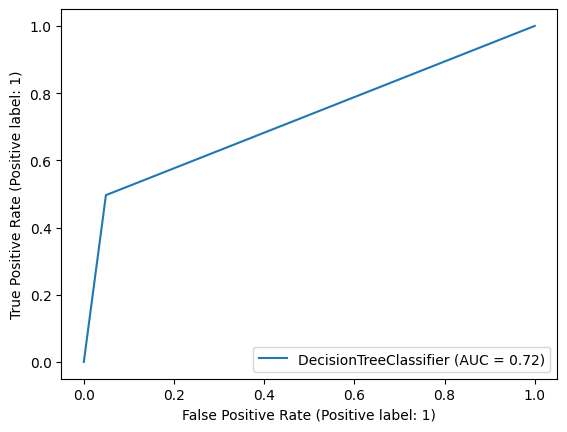

In [1085]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train, y_train)
y_train_dtc_pred = decision_tree_classifier.predict(X_train)
y_test_dtc_pred = decision_tree_classifier.predict(X_test)
print_result(y_train, y_train_dtc_pred, y_test, y_test_dtc_pred)
decision_tree_classifier_auc = RocCurveDisplay.from_estimator(decision_tree_classifier, X_test, y_test)

#### 3.5.2.2 Perform Logistic Regression using Decision Tree Classifier on the Test/Train Dataset

In [1086]:
y_unseen_dtc_pred = decision_tree_classifier.predict(X_unseen)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_dtc_pred})
output_df.to_csv('outputs/withoutpca/dtc.csv',index=False)

- Accuracy is perfect on the training. However, it's comparable in testing set though not perfect. 
- Precision is perfect in the training set.  However, it's comparable in testing set though not perfect. 
- Recall value is perfect in the training set.  However, it's comparable in testing set though not perfect. 

#### 3.5.3.1 Perform Logistic Regression using Decision Tree Classifier with GridCV on the Test/Train dataset.

Fitting 4 folds for each of 50 candidates, totalling 200 fits
              Train      Test
Accuracy   0.943555  0.947414
Precision  0.740000  0.747253
Recall     0.482609  0.496350


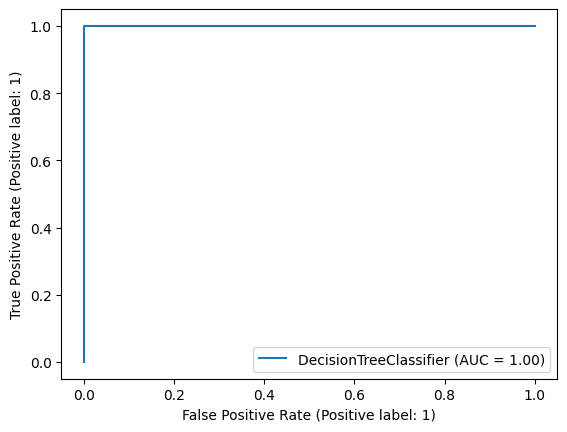

In [1087]:
decision_tree_classifier_gridcv = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search_classifier = GridSearchCV(estimator = decision_tree_classifier_gridcv, 
                           param_grid = params, 
                           cv = 4, n_jobs = -1, verbose = 1, scoring = "accuracy")

grid_search_classifier.fit(X_train, y_train)
grid_search_model = grid_search_classifier.best_estimator_
y_train_dtc_gridcv_pred = grid_search_model.predict(X_train)
y_test_dtc_gridcv_pred = grid_search_model.predict(X_test)
print_result(y_train, y_train_dtc_gridcv_pred, y_test, y_test_dtc_gridcv_pred)
grid_search_model_auc = RocCurveDisplay.from_estimator(grid_search_model, X_test, y_test_dtc_gridcv_pred)

- Accuracy on the training and testing set is comparable.
- Precision is quite high in the training set while lagging in the testing set.
- Recall value improved in both the training and testing set. However, still stays low in the testing set indicating model being unable to determine the **True** Positives.

**Overall, the Decision Tree model seems to be doing decent in terms of the various metrics.**

#### 3.5.3.2 Perform Logistic Regression using Decision Tree Classifier with GridCV on the unseen dataset.

In [1088]:
y_unseen_dtc_gridcv_pred = grid_search_model.predict(X_unseen)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_dtc_gridcv_pred})
output_df.to_csv('outputs/withoutpca/dtcgridcv.csv',index=False)

#### 3.5.4.1 Perform Logistic Regression using Adaboost Classifier on the Test/Train dataset.

              Train      Test
Accuracy   0.944770  0.943412
Precision  0.724138  0.686275
Recall     0.529565  0.510949


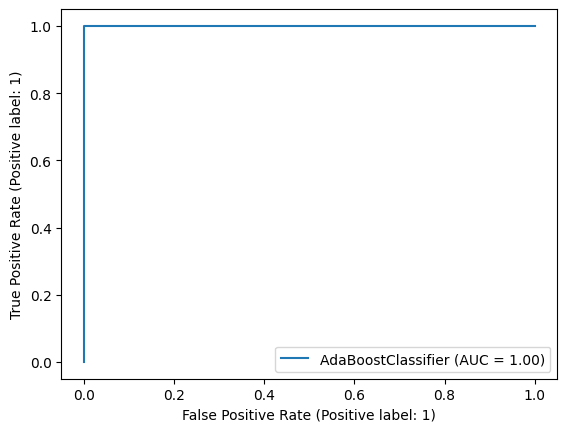

In [1089]:
adaboost_classifier = AdaBoostClassifier(n_estimators = 200, random_state=1)

adaboost_classifier.fit(X_train, y_train)
y_train_adaboost_pred = adaboost_classifier.predict(X_train)
y_test_adaboost_pred = adaboost_classifier.predict(X_test)
print_result(y_train, y_train_adaboost_pred, y_test, y_test_adaboost_pred)
adaboost_classifier_auc = RocCurveDisplay.from_estimator(adaboost_classifier, X_test, y_test_adaboost_pred)

#### 3.5.4.2 Perform Logistic Regression using Adaboost Classifier on the unseen dataset.

In [1090]:
y_unseen_adaboost_pred = adaboost_classifier.predict(X_unseen)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_adaboost_pred})
output_df.to_csv('outputs/withoutpca/adaboost.csv',index=False)

- Accuracy on the training and testing set is comparable.
- Precision is quite high in the training set while lagging in the testing set.
- Recall value improved in both the training and testing set. However, still stays low in the testing set indicating model being unable to determine the **True** Positives.

**Overall, the Adaboost model seems to be doing better than the Decision Tree Model in terms of the various metrics.**

#### 3.5.5.1 Perform Logistic Regression using Random Forest with GridCV on the Test/Train dataset.

Fitting 4 folds for each of 144 candidates, totalling 576 fits
              Train      Test
Accuracy   0.955987  0.947414
Precision  0.884726  0.747253
Recall     0.533913  0.496350


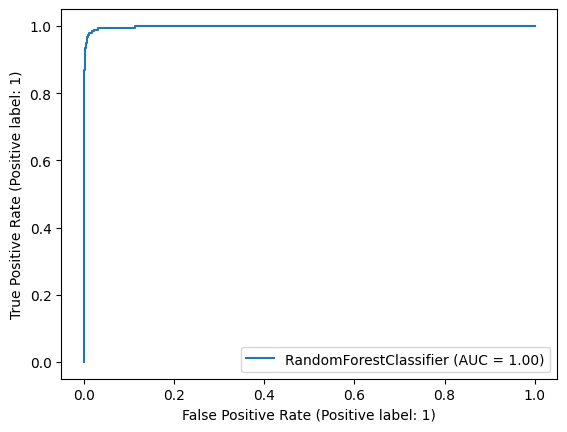

In [1104]:
random_forest_gridcv_classifier = RandomForestClassifier(n_estimators = 10, max_depth = 4, max_features = 20, random_state = 100)
params = {
    'max_depth': [2, 3, 5, 10 , 20, 50],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'n_estimators': [10, 25, 50, 100]
}
random_forest_gridcv_classifier = GridSearchCV(estimator = random_forest_gridcv_classifier, 
                                      param_grid = params, 
                                      cv = 4, 
                                      n_jobs = -1, 
                                      verbose = 1, 
                                      scoring = "accuracy")

random_forest_gridcv_classifier.fit(X_train, y_train)
random_forest_model = random_forest_gridcv_classifier.best_estimator_

y_train_randomforestgridcv_pred = random_forest_model.predict(X_train)
y_test_randomforestgridcv_pred = grid_search_model.predict(X_test)
print_result(y_train, y_train_randomforestgridcv_pred, y_test, y_test_randomforestgridcv_pred)
random_forest_model_auc = RocCurveDisplay.from_estimator(random_forest_model, X_test, y_test_randomforestgridcv_pred)

#### 3.5.5.2 Perform Logistic Regression using Random Forest on the unseen dataset.

In [1092]:
y_unseen_randomforestgridcv_pred = random_forest_model.predict(X_unseen)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_randomforestgridcv_pred})
output_df.to_csv('outputs/withoutpca/randomforest.csv',index=False)

- Accuracy on the training and testing set is comparable.
- Precision is quite high in both the training set.
- Recall value improved in both the training and testing set. However, still stays low in the testing set indicating model being unable to determine the **True** Positives.

**Overall, the Random Forest model seems to be doing better than the Adaboost model (with higher precision values) in terms of the various metrics.**

#### 3.5.6.1 Perform Logistic Regression using XGBoost on the PCA transformed Test/Train dataset.

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.943 total time=   0.5s
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.945 total time=   0.5s
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.937 total time=   0.5s
[CV 1/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.940 total time=   0.6s
[CV 5/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, scale_pos_weight=1, subsample=0.8;, score=0.945 total time=   0.6s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.25, max_depth=10, n_estimators=25, scale_pos_weight=1, subsam

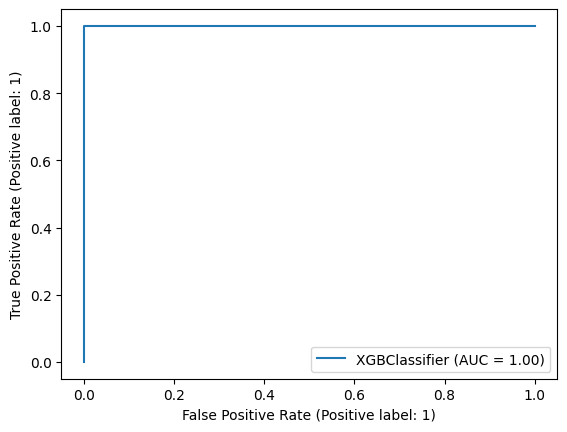

In [1093]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [10, 25, 50, 100],
    'max_depth': [2, 3, 5, 10 ,20, 50],
    'scale_pos_weight': [1],
    'gamma': [0.1, 0.5, 1, 1.5, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
}

folds = 5

param_comb = 800

xgboost_classifier = xgb.XGBClassifier(n_jobs = -1, objective = 'binary:logistic') # default paramters
xgboost_gridcv_classifier = RandomizedSearchCV(xgboost_classifier, param_distributions=params, n_iter=param_comb, verbose=3, scoring='accuracy', n_jobs = -1, cv = 5, random_state=42)
xgboost_gridcv_classifier.fit(X_train, y_train)

xgboost_model = xgboost_gridcv_classifier.best_estimator_
xgboost_model.fit(X_train, y_train)
y_train_xgb_pred = xgboost_model.predict(X_train)
y_test_xgb_pred = xgboost_model.predict(X_test)
print_result(y_train, y_train_xgb_pred, y_test, y_test_xgb_pred)
xgboost_model_auc = RocCurveDisplay.from_estimator(xgboost_model, X_test, y_test_xgb_pred)

- Accuracy on the training and testing set is comparable. [BEST]
- Precision is very high the training set. The precision in test set is also quite high and comparable. [BEST]
- Recall is very high in the training set. Recall value improved in the testing set too. [BEST]

**Overall, the XGBoost model seems to be doing decent in terms of the various metrics.**

#### 3.5.6.2 Perform Logistic Regression using XGBoost on the unseen dataset.

In [1094]:
y_unseen_xgboost_pred = xgboost_model.predict(X_unseen)
output_df = pd.DataFrame({'id': X_unseen_id, 'churn_probability': y_unseen_xgboost_pred})
output_df.to_csv('outputs/withoutpca/xgboost.csv',index=False)

# 4. Feature Selection

## 4.1 Model parameters using XGBoost Model

<Axes: >

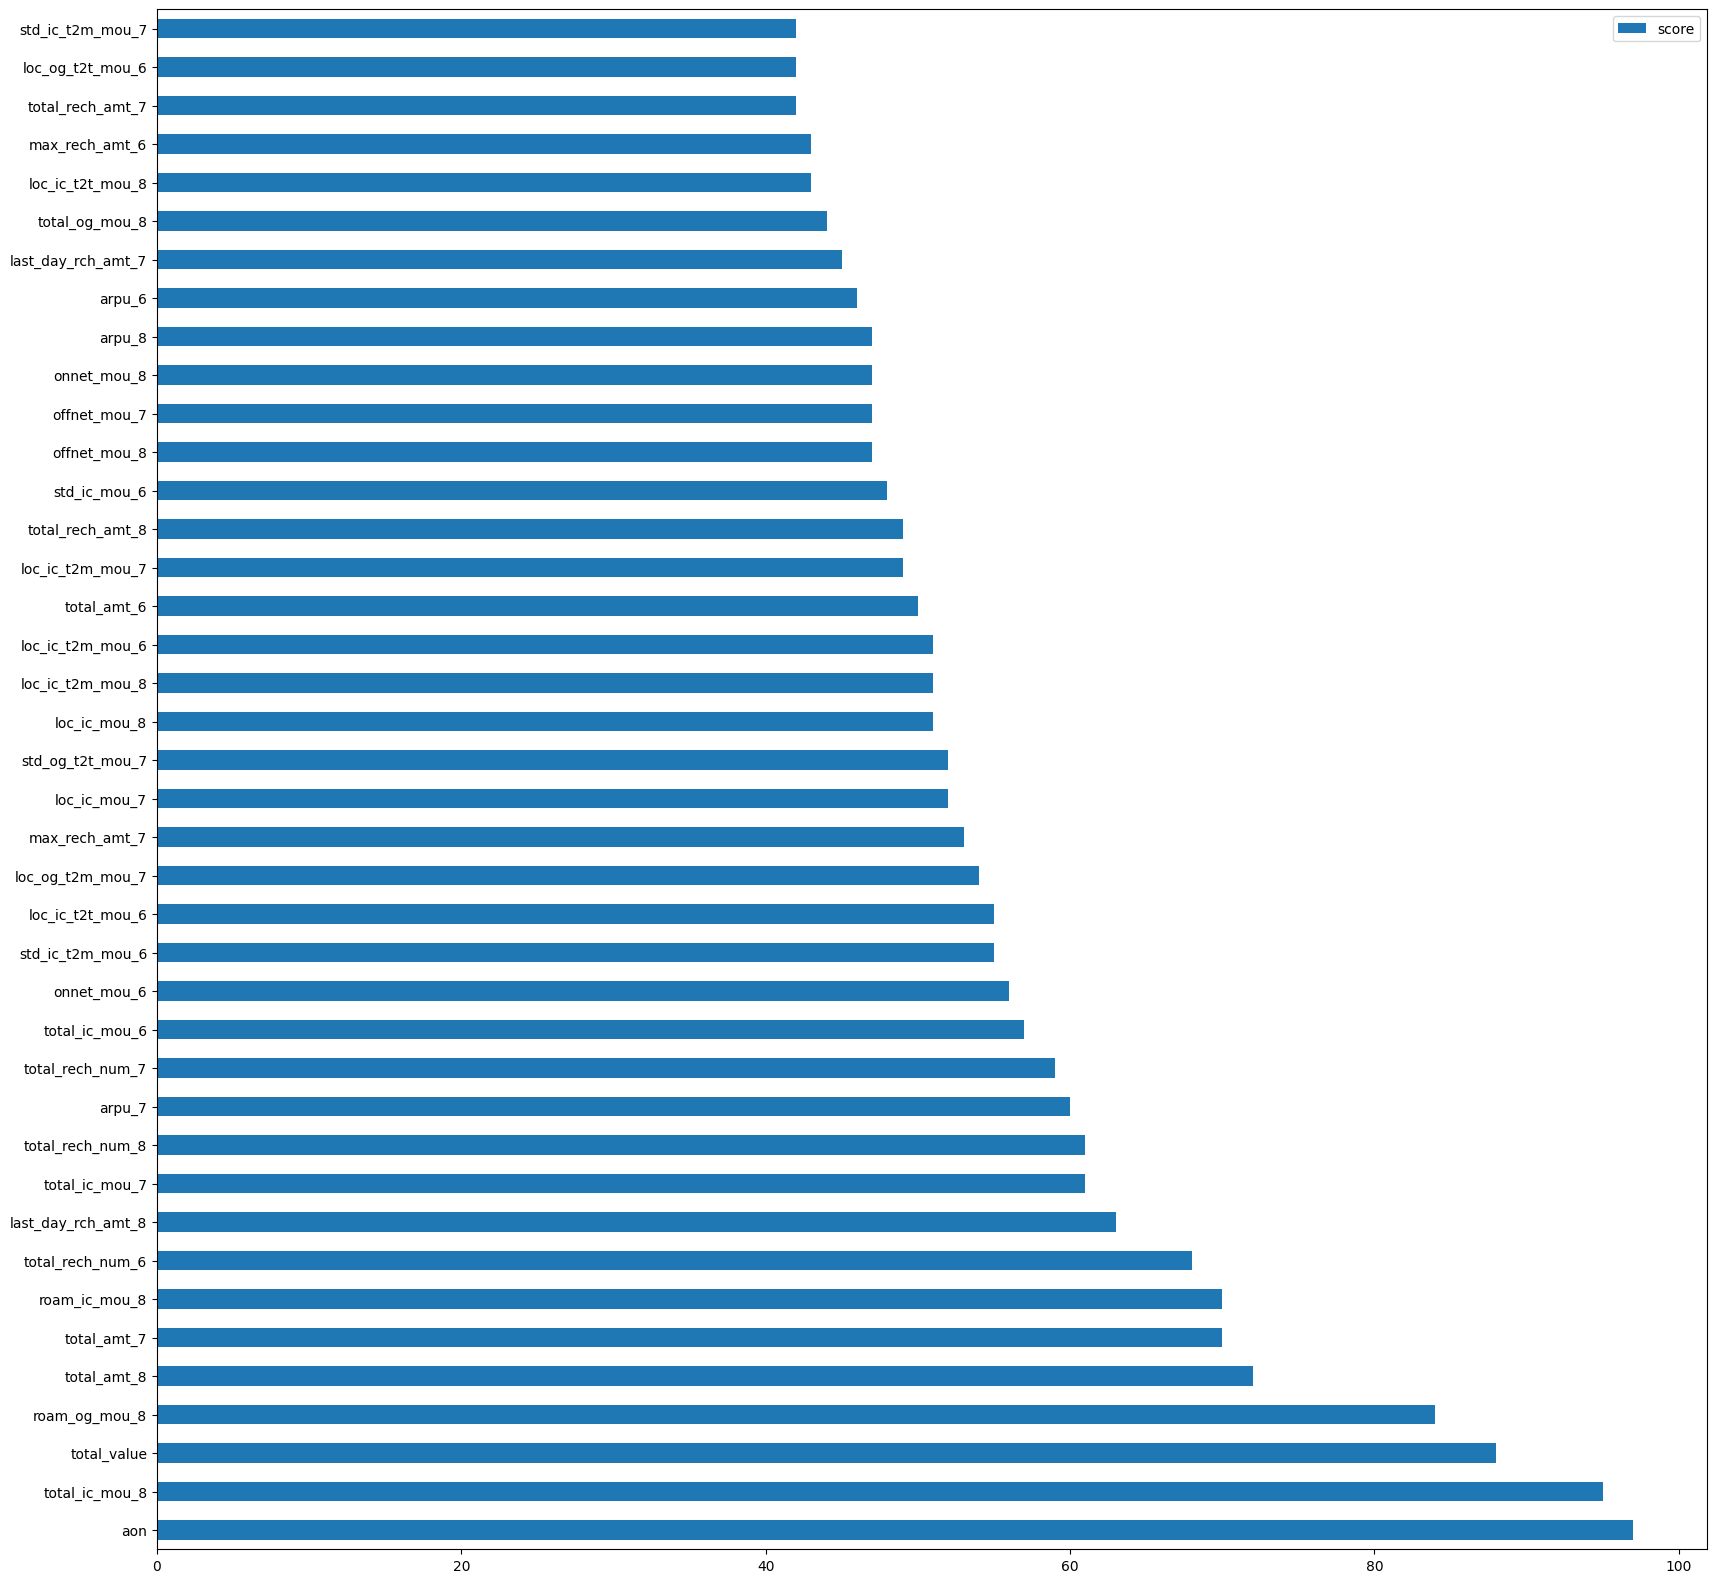

In [1105]:
feature_important = xgboost_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,20))

## 4.2 Model parameters using Random Forest Model

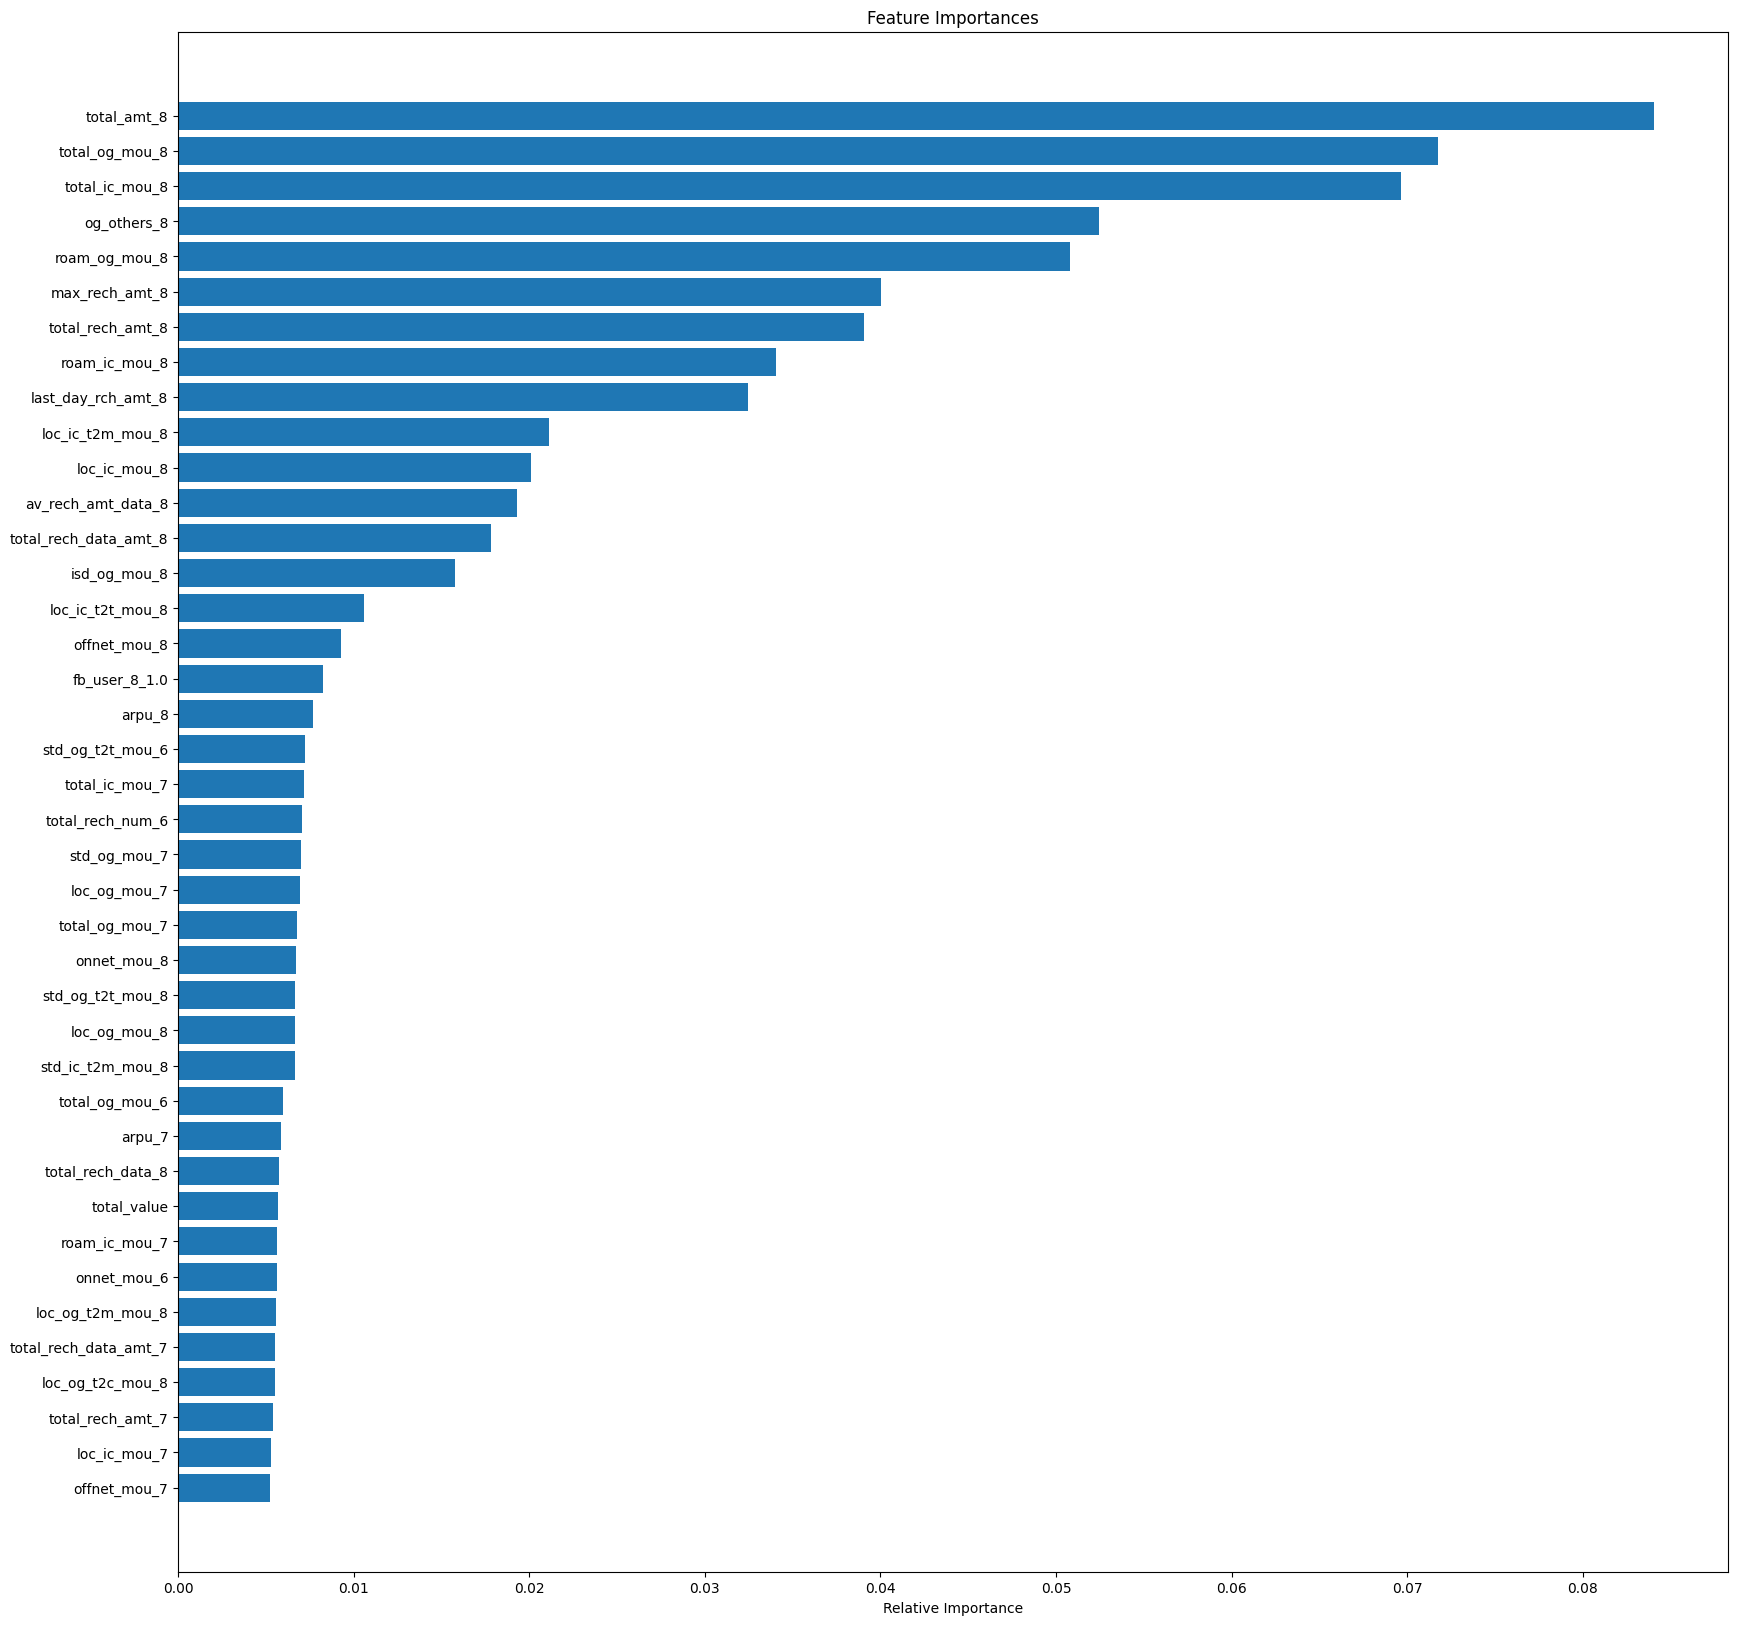

In [1107]:
features = X_train.columns
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[-40:]

plt.figure(figsize=(20,20))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

5. Final Observations/Summary

- Experimented with different models:
   - Logistic Regression
   - Decision Tree Classifier
   - Decision Tree Classifier using GridCV
   - Adaboost Classifier
   - Random Forest Classifier using GridCV
   - XGBoost Classifier

- Experimented different models for their accuracy after applying PCA (Principal Component Analysis) to reduce dimensionality.
- Experimented different model behavior after applying SMOTE analysis to the input data with the intention to correct the imbalance. However, the SMOTE conversion did not provide considerable improvments in the Precision & Recall value for the Test Data Set.
- XGBoost model performs very well with both PCA and non-PCA Input Dataset. Hence considering the XGBoost model as the final model.



#### XGBoost without PCA

|Parameter|Train|Test|
|-|-|-|
|Accuracy|0.991498|0.948843|
|Precision|0.995197|0.751323|
|Recall|0.900870|0.518248|

#### XGBoost with PCA

|Parameter|Train|Test|
|-|-|-|
|Accuracy|0.982638 | 0.930552|
|Precision|0.998900|0.678161|
|Recall|0.789565|0.215328|
  
All Other models, although showing promising accuracy in the training phase, perform poorly on the test set based on the combination of Accuracy, Precision and Recall values. In the context of telecom churn, where minimizing churn rate is crucial, accuracy emerges as the most pertinent metric. Hence, based on this criterion, the **XGBoost without PCA** stands out as the most suitable choice among all alternatives.

Based on the analysis of our XGBoost, here are some business ideas to improve churn rate:

- **Average On Network** seems to be top contributor suggesting churning is driven mostly by customers due to their association with the provider. 

- **Incoming call** for all the three month seems to be playing a key role. (total_ic_mou_8, total_ic_mou7 & total_ic_mou_6).

- **Roaming Outgoing and Incoming calls** for month 8 has significant impact. (roam_og_mou_8, roam_ic_mou_8).
    - Better roaming offers 

- **T2M Category - Operator T to other operator mobile** across categories STD, LOC.
    - Better offers for STD/LOCAL calling to other operators.

- **Recharge Parameters** - Specifically Data Recharge, Recharge Values
    - Better offers for Data Recharges

- Interestingly FBUser packs seems to be a contributing factor
    - Better incentives for FB packages